# Lesser Ury, imprissionist

<div style="text-align: center;">
  <img src="https://upload.wikimedia.org/wikipedia/commons/6/66/Lesser_Ury_1910_Selbstportr%C3%A4t_mit_Pinsel_und_Palette.JPG" alt="Lesser Ury Selbstporträt" width="300">
</div>




One Saturday morning, I visited an Impressionist exhibition at the Tel Aviv Museum of Art. The exhibition was small, but it left a lasting impression. The biggest discovery for me was **Lesser Ury** *(1861–1931)*, a German artist who was passionately in love with Berlin. His works caught my attention, and I decided to dive deeper into his art through a data-driven research project.

The goal of my project is to use quantitative analysis to explore his artistic legacy. Through characteristics like color palette, choice of subjects, painting sizes, and even materials used, I want to understand what he painted (*genre*), possibly how he did it (the *technique* and *support*), and speculate about who his audience was (for example, large paintings are often created on commission).

However, gathering relevant data turned out to be a challenge. Most of Ury’s works are in private collections, and I couldn’t find a comprehensive catalog of his paintings. I decided to postpone searching for printed monographs and detailed studies to avoid bias in my own analysis. Instead, I chose a more practical approach: researching auction aggregator websites. My primary source was [**Artsy**](https://www.artsy.net/artist/lesser-ury?metric=in), which provided data on paintings that had been sold at auction.

Based on the data I collected (181 observations), I created an initial dataset for analysis. While it’s not perfectly representative (since it only includes paintings that were sold, which introduces bias), it’s suitable for getting a first impression of the artist’s work.


In [562]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'iframe'
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from wordcloud import WordCloud

import os
import requests
import cv2
import ast

import scipy.stats as stats
from scipy.stats import binomtest, ttest_ind, shapiro, levene, mannwhitneyu
import nltk
from nltk.corpus import stopwords
from collections import Counter
import re
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.util import ngrams
from itertools import combinations
from scipy.stats import kruskal
import scikit_posthocs as sp
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


In [460]:
# load the dataset into DataFrame
df = pd.read_csv('/Users/victorakulinin/Projects/lesser-ury-art-analysis/lesser_ury_list_handl_v2.csv')

# extract the random sample to inspect the data
df.sample(5)

# retrive the metadata about the dataset
df.info()

,id,title,year,genre,technique,support,dimensions_h_w,location,url_imagine
19,20,"Café de la Paix bei Nacht, Paris",1928,cityscape,oil,canvas,23.7 × 32.5,Private collection,https://www.ludorff.com/assets/images/_large96...
162,164,"Galerie im Café Vaterland am Potsdamer Platz, ...",1920,interior scene,oil,canvas,32.6 x 24.4,Private collection,https://d7hftxdivxxvm.cloudfront.net/?height=4...
104,106,Devorah,1920,portrait,oil,canvas,56 x 43,Private collection,https://d7hftxdivxxvm.cloudfront.net/?height=4...
69,71,Blick auf den Rhein,1904,landscape,oil,panel,12.6 x 22.8,Private collection,https://d7hftxdivxxvm.cloudfront.net/?height=4...
80,82,Brandenburger Tor vom Pariser Platz aus gesehen,1928,cityscape,pastel,board,35 x 50,Private collection,https://d7hftxdivxxvm.cloudfront.net/?height=4...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181 entries, 0 to 180
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              181 non-null    int64 
 1   title           181 non-null    object
 2   year            181 non-null    int64 
 3   genre           181 non-null    object
 4   technique       181 non-null    object
 5   support         181 non-null    object
 6   dimensions_h_w  181 non-null    object
 7   location        181 non-null    object
 8   url_imagine     181 non-null    object
dtypes: int64(2), object(7)
memory usage: 12.9+ KB


So, we have a dataset with 9 variables and 181 observations:

- **id**: unique identifier of the painting.
- **title**: the original title of the painting.
- **year**: the year the painting was created.\
  IMPORTANT: Lesser Ury did not always date his paintings, so the date may not be exact. Sometimes only the range of years during which the painting was created is known (e.g., "1890–1895"), and in such cases, the first year of the range is used.
- **genre**: the genre of the painting (e.g., portrait, landscape).
- **technique**: the technique used to create the painting (e.g., oil, watercolor).
- **support**: the material of the painting's base (e.g., canvas, paper).
- **dimensions_h_w**: the height (h) and width (w) of the painting in centimeters.
- **location**: the presumed location of the painting.
- **url_imagine**: direct link to the image.

**Data types**:\
The variables `id` and `year` are numerical.\
`title`, `genre`, `technique`, `support`, and `location` are categorical.\
`dimensions_h_w` is a numerical pair.\
`url_imagine` is a string.

Before beginning the analysis, it is necessary to check the data for duplicates and ensure the dimensions_h_w field is correctly filled. Special attention should be paid to the decimal separator ('.') and the absence of typos (e.g., "Х" instead of "х").

In [461]:
# let's check the duplicates
df.duplicated().sum()

np.int64(0)

Well, no one duplicate it's good.\
Now, let's fix any incorrect values.

In [462]:
# format conversion
df['dimensions_h_w'] = (
    df['dimensions_h_w']
    .str.replace(',', '.', regex=False)  # replace a coma with a dot
    .str.replace('×', 'x', regex=False)  # replace × with x
    .str.replace('х', 'x', regex=False)  # replace Cyrillic х with x
    .str.replace('Х', 'x', regex=False)  # replace Х with x
)

In [463]:
# calculate summary statistics for all columns
df.describe(include = 'all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,181.0,NaN,NaN,NaN,91.81768,52.654059,1.0,47.0,92.0,137.0,182.0
title,181,181,Unter den Linden nach dem Regen,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
year,181.0,NaN,NaN,NaN,1910.143646,14.595331,1878.0,1896.0,1915.0,1922.0,1928.0
genre,181,10,landscape,59,NaN,NaN,NaN,NaN,NaN,NaN,NaN
technique,181,8,oil,77,NaN,NaN,NaN,NaN,NaN,NaN,NaN
support,181,10,canvas,66,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dimensions_h_w,181,173,35 x 50,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
location,181,5,Private collection,177,NaN,NaN,NaN,NaN,NaN,NaN,NaN
url_imagine,181,181,https://upload.wikimedia.org/wikipedia/commons...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Progress Update**\
We’ve successfully uploaded the dataset of Lesser Ury’s works. It’s not a large dataset—I compiled it myself and made sure to avoid duplicates and missing data during the collection process. As a result, everything came together smoothly.

Now we have a dataset with 181 unique painting ***titles***, all created between 1878 and 1928. The dataset includes 10 unique ***genres***, with *landscape*s being the most common (not surprising for an Impressionist). *Oil* painting was the most frequently used ***technique***, though there are 8 other techniques listed. As for the painting ***support***, there are 10 unique types, with *canvas* being the clear favorite.\
One particularly interesting observation is about the ***dimensions*** variable: there are 173 unique sizes out of 181 records. That’s an impressive variety, almost as if Ury completely ignored any standard dimensions. This is definitely worth a closer look.\
On the other hand, the ***location*** variable was more predictable. As I noticed during the data collection phase, most paintings (177 out of 181) are in private collections.\
As for the ***image links*** — they’re all unique, so no issues there.

**What’s next?** \
Next, I’ll take a closer look at each variable, starting with the *`year`* the paintings were created.\
Let’s keep going!

## Year

Let’s start by extracting the data and taking a look at the distribution of paintings by year.

In [464]:
# obtaining the data
year = df[['id', 'year']].copy()
year.sample(5)

,id,year
157,159,1926
123,125,1897
79,81,1894
80,82,1928
94,96,1925


In [465]:
# get the data for chart
year_count = year['year'].value_counts().reset_index().sort_values(by = 'year', ascending = True)
year_count.columns = ['year', 'count']
year_count.sample(5)

,year,count
1,1924,15
7,1926,7
14,1913,3
4,1928,9
37,1911,1


In [466]:
# make the barplot
fig = px.bar(year_count, 
             x = 'year', 
             y = 'count', 
             title = "Distribution of Paintings by Year<br><i>Questionable dating, but an undeniable achievement!</i>",
             labels = {"year": "year", "count": "number of paintings"},
             color_discrete_sequence = ['lightblue']) 

# set the color for backstage
fig.update_layout(
    plot_bgcolor = 'white',
    paper_bgcolor = 'white',
    title_x = 0.5,  
)

# adding the line for the average value
mean_value = np.round(year_count['count'].mean(), 0)
fig.add_shape(type = "line", 
              x0 = year_count['year'].min(), 
              y0 = mean_value, 
              x1 = year_count['year'].max(), 
              y1 = mean_value, 
              line = dict(color = "brown", width = 2, dash = "dash"))

# adding a lable for the average value
fig.add_annotation(x = year_count['year'].min() + 3, 
                   y = mean_value + 0.9, 
                   text = f'Mean ({mean_value:.0f})', 
                   showarrow = False, 
                   font = dict(color = 'gray'))

# adding a label for the max value
max_value = year_count['count'].max()
max_year = year_count.loc[year_count['count'] == max_value, 'year'].values[0]
fig.add_annotation(x = max_year, 
                   y = max_value + 0.8, 
                   text = f'Max ({max_value})', 
                   showarrow = False,  
                   font = dict(color = 'gray'))

# changin the charts size
fig.update_layout(
    height = 600, 
    width = 1000,
)
# show the chart
fig.show();

In [467]:
# let’s gather some additional statistics
year_count.describe().T

,count,mean,std,min,25%,50%,75%,max
year,39.0,1902.846154,15.272160,1878.0,1891.0,1903.0,1914.0,1928.0
count,39.0,4.641026,6.343199,1.0,1.0,2.0,6.0,37.0


Based on the dating of the paintings, the period covered spans **51 years** (1928–1978, plus 1 year since both the start and end years are included). However, we have data for only **39 unique years**, meaning **12 years are missing** — nearly 25% of the total period.\
The most frequent occurrence is just 1 painting per year, while the median reaches 2, and the average climbs to 5. The progression of the mode, median, and mean in ascending order points to a right-skewed distribution, suggesting there may be outliers.\
The numbers are small, so calculating the interquartile range (IQR) and the upper boundary is straightforward, even without a calculator. With Q1 = 1 and Q3 = 6, the *upper boundary is 13.5* (there’s no lower boundary as Q1 = 1).\
This identifies two years with outlier values for the number of paintings:
- **1920**: 37 paintings
- **1924**: 15 paintings

Alright, let's keep that in mind and move on.\
To make the analysis more meaningful, let’s group the data into broader time frames, replacing specific years with ***creative periods***— *major stages in the artist’s life, each with its own distinct characteristics*. Based on the available materials about Lesser Ury’s work, I’ve identified the following periods:
- **1862–1879: Early Learning Period**\
  A time of early exploration, self-discovery, and initial steps in art.
- **1880–1888: Paris & Munich Period**\
  The years of studying and working in Paris and Munich, where he adopted elements of Impressionism and academic painting.
- **1889–1920: Berlin Period**\
  The peak of his creative output, focused on street scenes and Berlin’s urban life.
- **1921–1931: Late Period**\
  A later phase marked by an increase in religious and biblical themes, likely influenced by his Jewish heritage and cultural context of the time.

Now, let’s analyze the distribution of paintings across these periods

In [468]:
# determination of periods 
bins = [-float('inf'), 1879, 1888, 1920, float('inf')]
labels = ['Early learning period', 'Paris and Munich period', 'Berlin period', 'Late period']

# using pd.cut for classification
year['period'] = pd.cut(year.year, bins=bins, labels=labels)
year.sample(5)

,id,year,period
165,167,1912,Berlin period
121,123,1920,Berlin period
29,30,1924,Late period
150,152,1925,Late period
19,20,1928,Late period


In [469]:
# get the data for chart
periods = year['period'].value_counts().sort_values(ascending=False)

# computing the average
mean_paintings = np.mean(periods.values)

# let's prepare the data for chart
data = {
    "period": periods.index,
    "count": periods.values,
}

# setting up custom text for tooltips
custom_text = [
    (p, c, mean_paintings) for p, c in zip(data['period'], data['count'])
]

# make the chart
fig = go.Figure()
fig.add_trace(
    go.Bar(
        x = data["period"],
        y = data["count"],
        marker = dict(color=px.colors.qualitative.Pastel),
        customdata = custom_text,
        hovertemplate = (
            "Period: %{customdata[0]}<br>"
            "Paintings: %{customdata[1]}<br>"
            "Total Mean Paintings: %{customdata[2]:.0f}<extra></extra>"
        ),
    )
)

# layout customization
fig.update_layout(
    title = "Distribution of Paintings by Period<br><i>Berlin leaves all the others in its shadow!</i>",
    xaxis_title = "period",
    yaxis_title = "number of paintings",
    plot_bgcolor = 'white',  
    paper_bgcolor = 'white', 
    margin = dict(l = 50, r = 50, t = 100, b = 50),  
    xaxis = dict(showgrid=False),
    yaxis = dict(showgrid=False),
)

# set up the chart size
fig.update_layout(
    height = 600,  # Высота графика
    width = 1000,  # Ширина графика
)

# show the chart
fig.show();


In [470]:
# let's gather additional statistics about the periods
period_duration = year.groupby('period').agg(
    duration = ('year', lambda x: (x.max() - x.min()) + 1), # calculating period durations
    n_paintings = ('id', 'count'), # counting the number of paintings per period
    n_missing_years = ('year', lambda x: ((x.max() - x.min()) + 1) - len(x.unique())) # counting the number of missing years per period
).reset_index()           

# calculating the number of paintings per year and rounding to the nearest whole number
period_duration['paintings_per_year'] = (
    period_duration['n_paintings'] / (period_duration['duration'] - period_duration['n_missing_years'])).apply(np.round).astype(int)

# displaying the final table
period_duration

/var/folders/sq/16xkf9wd67z_11jb75f4_5tw0000gn/T/ipykernel_21233/3210351671.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



,period,duration,n_paintings,n_missing_years,paintings_per_year
0,Early learning period,2,2,0,1
1,Paris and Munich period,9,13,3,2
2,Berlin period,32,119,8,5
3,Late period,7,47,0,7


We have four creative periods, with the **Berlin Period** clearly dominating with **119**  paintings — nearly twice as many as all the other periods combined. One reason for this outcome could be the length of the Berlin Period, which spans more than half of the artist’s creative journey —*32 out of 51* years. However, when looking at painting density (the ratio of paintings to years), the **Late Period** shows the highest intensity: **7** paintings per year compared to 5 in the Berlin Period.

**Progress Update**

We analyzed the **Year** variable from our dataset and found 39 unique values. What does this mean?\
Lesser Ury lived for nearly 70 years, but it's unlikely that any preserved works came from the first 10 years of his life. Thus, the dataset covers more than half of his creative journey — approximately 65%. However, the works are not evenly distributed across the years. In most cases, there’s just one painting per year, yet the average is 5 paintings per year due to two exceptionally productive years:
- **1920**: 37 paintings (the maximum value)
- **1924**: 15 paintings.

Can we consider these years unique? Probably not. As mentioned earlier, `*some paintings in the sources are dated approximately, such as "circa 1XXX" or even a range like "1XXX–1XXX." In such cases, the dataset includes the earliest available date*`.\
To better understand these peaks, we should consider the medium used. If the 37 paintings from 1920 were pencil or charcoal drawings, such productivity might be realistic. However, if they are large-scale oil paintings, this would be an extraordinary achievement. We’ll revisit this question later when exploring other variables.

Now, let’s examine the distribution of paintings across creative periods:
- **Early Period**: 2 paintings over 2 years.
- **Paris & Munich**: 13 paintings over 9 years.
- **Berlin Period**: 119 paintings over 32 years.
- **Late Period**: 47 paintings over 7 years.

On the one hand, we have paintings from all four periods, providing a well-rounded view. On the other hand, the distribution is highly uneven. The *Berlin Period* dominates in total numbers, but in terms of *density* (paintings per year), the *Late Period* leads with 7 paintings per year, compared to 5 in the *Berlin Period*, 2 in the *Paris & Munich* period, and 1 in the *Early Period*.

Does this mean that Ury's more "mature" works are more highly valued? Partially, yes. It’s common for artists to have their most refined works valued more highly. However, the scarcity of early works could be explained by several factors. First, Ury himself may have viewed them as practice pieces and did not attribute much significance to them. Second, early buyers might not have seen their value due to the artist's lack of fame at the time, and the works may simply have not been preserved.

To draw more precise conclusions, we would need to analyze a complete catalog of his known works.

Now, let’s move on to the next variable — **Genre**.

## Genre

The process of defining a painting's genre can sometimes be just as creative as painting itself.\
There are always nuances. For example, how do you differentiate between a cityscape and an urbanscape? Both genres focus on cities, but cityscapes emphasize urban life — people, motion, and the emotions of the streets — while urbanscapes concentrate on architecture, structures, and the elements of the urban environment.\
Additionally, a single painting often incorporates elements from multiple genres. Where do we draw the line? The more details and layers of meaning a painting holds, the harder it becomes to assign it to a specific genre.\
For simplicity in this analysis, I identified 10 unique genres. Descriptions of each can be found below.

Main genres:
- **Cityscape**: Urban landscapes featuring buildings, streets, and elements of city architecture.
- **Landscape**: Natural landscapes, including fields, forests, rivers, lakes, and mountains.
- **Genre Scene**: Scenes from everyday life, often depicting people engaged in daily activities.
- **Interior Scene**: Depictions of indoor spaces, such as rooms, cafes, or other enclosed settings.
- **Figure Painting**: Artworks focusing on the human figure, emphasizing anatomy and proportions.

More specialized genres:
- **Seascape**: Maritime landscapes, including oceans, seas, and beaches.
- **Village Scene**: Depictions of rural life, showcasing village architecture and countryside settings.
- **Still Life**: Static objects such as fruits, flowers, and household items.
- **Portrait**: Artwork focusing on a person, emphasizing their face and expressions.

Next one - stood out to me as a unique genre. I wasn't ready to encounter them in an Impressionist work:
- **Biblical Scene**: Narratives from the Bible, often portraying religious figures and events.

Alright, and now - let’s start by exploring the distribution of paintings across genres.

In [471]:
# let's obtaining the data
genre = df[['id', 'genre']].copy()
genre.sample(5)

,id,genre
41,43,village scene
117,119,landscape
97,99,genre scene
96,98,landscape
120,122,cityscape


In [472]:
# let's get data for chart of distribution
genre_count = genre.groupby(['genre']).count().reset_index().sort_values(by = 'id', ascending = False)
genre_count.columns = ['genre', 'count']

In [473]:
# make the barplot
fig = px.bar(genre_count, 
             x = 'genre', 
             y = 'count', 
             title = "Distribution of Paintings by Genre<br><i>Impressionism, Berlin-style: Nature Takes Center Stage.</i>",
             labels = {"genre": "genre", "count": "number of paintings"},
             color_discrete_sequence = ['lightblue']) 

# set the color for backstage
fig.update_layout(
    plot_bgcolor = 'white',
    paper_bgcolor = 'white',
    title_x = 0.5,  
)

# adding the line for the average value
mean_value = np.round(genre_count['count'].mean(), 0)
fig.add_shape(type = "line", 
              x0 = -0.5, 
              y0 = mean_value, 
              x1 = 9.5, 
              y1 = mean_value, 
              line = dict(color = "brown", width = 2, dash = "dash"))

# adding a lable for the average value
fig.add_annotation(x = 9, 
                   y = mean_value + 1.5, 
                   text = f'Mean ({mean_value:.0f})', 
                   showarrow = False,  
                   font = dict(color = 'gray'))

# adding a label for the max value
max_value = genre_count['count'].max()
max_genre = genre_count.loc[genre_count['count'] == max_value, 'genre'].values[0]
fig.add_annotation(x = max_genre, 
                   y = max_value + 1.5, 
                   text = f'Max ({max_value})', 
                   showarrow = False,  
                   font = dict(color = 'gray'))

# changin the charts size
fig.update_layout(
    height = 600, 
    width = 1000,
)
# show the chart
fig.show();

In [474]:
# let's obtain additional statistics
genre_count.describe(include = 'all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
genre,10,10,landscape,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
count,10.0,NaN,NaN,NaN,18.1,22.575552,1.0,2.25,6.5,24.5,59.0


So, the *10* unique *genres* gave us a right-skewed distribution, though the tail is not as long as in the case of years.\
The average number of paintings per genre is 18, but only three (*landscape*, *cityscape*, and *genre scenes*) exceeded this figure.\
The *standard deviation* (22.58) is higher than the *average* (*18*), highlighting significant data dispersion. This is due to the uneven distribution of genres: most are represented by a small number of paintings (*median* is about *7*), while a few genres stand out significantly.

With Q1 = 2.25 and Q3 = 24.5, the *upper bound* calculation gave a value of *58*, landing right between the values for *landscape* and *cityscape*. This means we do have one **outlier** — **landscape**.

Now, let’s enrich our dataset with information about the creative periods and examine the distribution across these periods.

In [475]:
# add periods to the genre dataset by merging it with the 'years' dataset
genre = genre.merge(year[['id', 'period']], on = 'id')
genre.sample(5)

,id,genre,period
124,126,landscape,Paris and Munich period
5,6,interior scene,Berlin period
51,53,genre scene,Paris and Munich period
149,151,cityscape,Late period
44,46,cityscape,Berlin period


In [476]:
# extracting the data for the chart
genre_counts = genre.groupby(['genre', 'period']).size().reset_index(name='count')

/var/folders/sq/16xkf9wd67z_11jb75f4_5tw0000gn/T/ipykernel_21233/3580274977.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [477]:
# create the scatter plot
fig = px.scatter( genre_counts,
                 x='period',
                 y='genre',
                 size='count',
                 color='genre',
                 hover_name='genre',
                 size_max=60,
                 title='Distribution of Works Across Genres and Periods. <br><i> Berlin - the city that had it all!<i><br>'
)

# set the color for backstage
fig.update_layout(
    plot_bgcolor = 'white',
    paper_bgcolor = 'white',
    title_x = 0.5,  
)

# the legend adds unnecessary visual noise - let's remove it
fig.update_layout(showlegend=False)

# changin the charts size
fig.update_layout(
    height = 700, 
    width = 1000,
)

# show the chart
fig.show();

Of all the genres, only **landscape** appears in all four periods, which is not surprising — landscape painting was a convenient genre for experimenting with lighting and atmosphere. Its presence in the *Early learning period* gave it an advantage over **cityscape** (that two more paintings). Moreover, it is the only genre represented in this period.

Two other genres: **cityscape** and **genre scenes** — appear in the three periods.

In two periods, four genres appear: **biblical scenes**, **interior scene**, **portrait**, and **village scene**.

There are three genres that appear exclusively in the *Berlin period*: **figure painting**, **seascapes**, and **still lif**e.

An unexpected observation is the presence of **biblical scenes**, which appear in both the *Paris and Munich period* and the *Berlin period*, but are absent in the *Late period*. This period is noted precisely because Ury frequently turned to this genre during that time.

It’s also worth noting the steady number of **cityscape** paintings in the last two periods, while the number of **landscapes**, **genre scene**, and **interior scene** decreased almost fourfold. Has the Master grown tired of the city bustle and countryside trips? It’s impossible to say for certain — this dataset not able to provide that information.

**Progress Update**

It’s worth noting that our dataset represents only a sample of Ury’s sold works. This is not a reflection of overall demand but rather realized demand, meaning we are dealing with popular and highly liquid pieces.

Out of the 10 genres in our dataset, **landscape** and **cityscape** stand out as the most significant. Despite *landscape* slightly exceeding *cityscape* in the number of paintings, I still consider them equivalent. The difference between them is only two paintings (the sole entries from the Early learning period), which is about 3% of the total in the *landscape* category - hardly a substantial difference.

Following these, **genre scenes** comes in with 27 paintings, which is *less than 50%* of either of the leading genres. This is also the last genre to exceed the dataset’s average of *18 paintings per genre*.

We also discovered that the **Berlin period** was the most diverse in terms of genres, which is not surprising given its 30-year span - ample time for experimentation. Meanwhile, the **Paris and Munich periods**, along with the **Late period**, each featured *five genres*.

One notable observation is that **cityscape** was the only genre that consistently grew from period to period. Whether this was due to Ury’s increased focus on this genre or simply because later works in this genre are more appealing to collectors remains unclear. This question would require a deeper study.

Now, let’s explore the techniques Ury employed in his works.

## Technique

Firstly, let's take a look at the painting techniques accessible to Lesser Ury.

In [478]:
df['technique'].unique()

array(['oil', 'etching', 'pastel', 'litograph', 'drypoint', 'charcoal',
       'watercolor', 'pen'], dtype=object)

Let's describe all of them.

**Oil** - uses oil-based paints, often with linseed oil. Allows for rich colors, textures, layering, and easy blending.\
*Base*: Canvas, wood panel, or sometimes cardboard.\
*Advantages*: Durability, deep colors, layering options.\
*Disadvantages*: Slow drying, requires solvents for cleaning.

**Etching** - engraving on a metal plate (copper, zinc) using acid to create a design. The plate is then used for printing.\
*Base*: Paper, where the image is transferred.\
*Advantages*: High detail, can produce multiple copies.\
*Disadvantages*: Labor-intensive, uses toxic materials (acid).

**Pastel** - dry or oil-based sticks of pigment applied with soft transitions. Great for capturing light and color.\
*Base*: Textured paper or cardboard.\
*Advantages*: Vibrant colors, easy to apply.\
*Disadvantages*: Fragile, needs fixing for preservation.

**Litograph** - a printing technique based on the repelling properties of water and grease. The design is drawn with greasy material on stone or metal.\
*Base*: Special stone (lithographic limestone) or aluminum plate.\
*Advantages*: Can produce multiple copies, high-quality prints.\
*Disadvantages*: Size limitations, complex material preparation.

**Drypoint** - engraving directly on a metal plate with a needle, creating soft and velvety lines. No acid is used.\
*Base*: Metal plates, printed on paper.\
*Advantages*: Soft and rich lines, quick engraving process.\
*Disadvantages*: Limited prints, plate wears out quickly.

**Charcoal** - charcoal sticks create deep black lines and allow for intensity variations. Easily erased and blended.\
*Base*: Paper, canvas, cardboard.\
*Advantages*: Expressive lines, easy corrections.\
*Disadvantages*: Fragile material, needs fixing.

**Watercolor** - water-based paint that is transparent and light. Used for layering and creating atmospheric effects.\
*Base*: Paper specifically prepared for watercolor.\
*Advantages*: Light, quick drying, works well "wet-on-wet."\
*Disadvantages*: Hard to fix mistakes, requires special paper.

**Pen** - sharp lines used for graphic work and detailed drawings. Line thickness can vary.\
*Base*: Paper, sometimes parchment or cardboard.\
*Advantages*: Precision, long-lasting lines.\
*Disadvantages*: Hard to correct, limited gradient possibilities.

As we can see, three of these techniques—etching, lithography, and drypoint—are associated with the process of reproducing images, and this is intriguing. Why did he choose to use all of them?

<div style="background-color: #d4f1f9; padding: 10px; border-radius: 5px; color: #007acc;">
    <strong>Did You Know? (moment for some nitpicking):</strong>

The story of Etching, Litograph, and Drypoint is a journey through the evolution of printmaking, reflecting the creative needs and technological advancements of their times.

**Etching** emerged in the 15th century as an extension of the metalworking techniques used for armor decoration. Artists discovered that by covering a metal plate (often copper or zinc) with a waxy ground, they could draw designs into it using a needle. The plate would then be exposed to acid, which etched the drawn lines. This method offered unparalleled detail and allowed artists like Rembrandt to create dramatic and textured compositions. Etching became a favored technique for its ability to produce multiple copies of intricate designs, making art more accessible to collectors and enthusiasts. Its use continues today, appreciated for the depth and character of its lines.

**Litograph**, born in the late 18th century, was a revolutionary development based on the principle of oil and water repelling each other. Alois Senefelder, a German playwright, invented lithography in 1796 as a way to reproduce his scripts efficiently. Artists quickly adopted the technique because it allowed for freehand drawing on limestone with a greasy crayon. Unlike etching, no incisions were needed on the surface, preserving the immediacy of the artist's hand. Litograph was ideal for posters, illustrations, and fine art, making it a versatile tool in both commercial and artistic realms. Its ability to produce bold and clear images ensured its popularity in the 19th century, especially among the likes of Toulouse-Lautrec.

**Drypoint**, also dating back to the 15th century, involves directly scratching a design into a metal plate using a needle. Unlike etching, drypoint does not rely on acid, and the process creates burrs on the edges of the lines, resulting in a velvety, soft effect on the prints. Artists such as Albrecht Dürer and Mary Cassatt embraced drypoint for its intimate and expressive qualities. Because the burr wears down with repeated printing, drypoint is often chosen for small, exclusive editions. Its simplicity and directness make it a favorite for personal and delicate works.

These three techniques share a common thread: they were born from the desire to replicate and disseminate art. Artists choose them based on the unique qualities they offer. Etching provides precision and depth, perfect for dramatic or detailed compositions. Litograph excels in capturing the artist’s spontaneous hand and bold visuals, ideal for posters or illustrations. Drypoint lends itself to tender and expressive imagery, often reserved for intimate works or limited editions.

Together, they highlight the ingenuity of printmaking and its role in democratizing art while preserving the unique voice of the artist..
</div>


Well, so far we can see that Ury employed various techniques, demonstrating his willingness to experiment. Now, let's take a look at how this is reflected in the numbers.

In [479]:
# let's obtain the data on the techniques.
technics = df[['id','technique']].copy()
technics.sample(5)

,id,technique
31,32,etching
91,93,drypoint
27,28,pastel
58,60,oil
169,171,oil


In [480]:
# OK, now let's get data for chart of distribution
technics_count = technics.groupby(['technique']).count().reset_index().sort_values(by = 'id', ascending = False)
technics_count.columns = ['technique', 'count']

In [481]:
# and now, let's make the barplot
fig = px.bar(technics_count, 
             x = 'technique', 
             y = 'count', 
             title = "Distribution of Paintings by Tecnique<br><i>Oil and pastel are the 'Ginger and Fred' techniques in Ury's work.</i>",
             labels = {"technique": "technique", "count": "number of paintings"},
             color_discrete_sequence = ['lightblue']) 

# set the color for backstage
fig.update_layout(
    plot_bgcolor = 'white',
    paper_bgcolor = 'white',
    title_x = 0.5,  
)

# adding the line for the average value
mean_value = np.round(technics_count['count'].mean(), 0)
fig.add_shape(type = "line", 
              x0 = -0.5, 
              y0 = mean_value, 
              x1 = 7.5, 
              y1 = mean_value, 
              line = dict(color = "brown", width = 2, dash = "dash"))

# adding a lable for the average value
fig.add_annotation(x = 7, 
                   y = mean_value + 1.5, 
                   text = f'Mean ({mean_value:.0f})', 
                   showarrow = False,  
                   font = dict(color = 'gray'))

# adding a label for the max value
max_value = technics_count['count'].max()
max_genre = technics_count.loc[technics_count['count'] == max_value, 'technique'].values[0]
fig.add_annotation(x = max_genre, 
                   y = max_value + 1.5, 
                   text = f'Max ({max_value})', 
                   showarrow = False,  
                   font = dict(color = 'gray'))

# changin the charts size
fig.update_layout(
    height = 600, 
    width = 1000,
)
# show the chart
fig.show();

In [482]:
# calculating additional statistics
technics_count.describe(include = 'all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
technique,8,8,oil,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
count,8.0,NaN,NaN,NaN,22.625,28.868854,1.0,4.75,10.5,26.75,77.0


So, we see two clear leaders among the techniques: oil and pastel. These are the only ones that exceeded the average (23 paintings), which shows they were the main methods used by Ury. The distribution of the sample, as expected, is skewed to the right.

The IQR calculation, with Q1 = 4.75 and Q3 = 26.75, gave an upper boundary of 60. This excluded oil, which went beyond the limit, and was just one unit higher than pastel.

Interestingly, this situation is very similar to the one with genres. It might be related to the techniques used in works of these genres.

Let’s check this hypothesis. But first, we have a total of eight techniques, but due to the small dataset, some are represented by only a few works. I suggest grouping the techniques as follows:

**Painting Techniques**: Methods using paints or pigments that convey richness in color and tone, typically applied with a brush or palette.
Values: 'oil', 'pastel', 'watercolor'.
**Graphic Techniques**: Methods based on lines, strokes, or prints. These focus on textures and shapes and are often associated with printmaking or drawings.
Values: 'etching', 'litograph', 'drypoint', 'charcoal', 'pen'.

In [483]:
# create the dictionary to categorize the groups
tech_groups = {
    'painting': ['oil', 'pastel', 'watercolor'],
    'graphic': ['etching', 'litograph', 'drypoint', 'charcoal', 'pen']
}

# make the function to asign the groups
def assign_group(technique):
    """ Assigns a predefined group to a given artistic technique.

    This function iterates through a global dictionary `tech_groups` (assumed to be defined elsewhere),
    which maps group names to lists of associated techniques. If the input `technique`
    is found within any of these lists, the corresponding group name is returned.

    :param technique: A string representing an artistic technique (e.g., "Oil on canvas").
    :return: A string representing the assigned group name if the technique is found,
             otherwise returns `None` if the technique is not present in any group.
    """
    for group, techniques in tech_groups.items():
        if technique in techniques:
            return group
    return None  # if a value is missing in the dictionary

# adding the column 'tech_group'
technics['tech_group'] = technics['technique'].apply(assign_group)

technics.sample(5)

,id,technique,tech_group
172,174,oil,painting
100,102,pastel,painting
49,51,drypoint,graphic
28,29,etching,graphic
142,144,litograph,graphic


In [484]:
# add genres to the technique dataset by merging it with the 'genre' dataset
technics = technics.merge(genre[['id', 'genre']], on = 'id')
technics.sample(5)

,id,technique,tech_group,genre
0,1,oil,painting,cityscape
68,70,pastel,painting,landscape
11,12,oil,painting,figure painting
146,148,oil,painting,landscape
48,50,drypoint,graphic,genre scene


path=['tech_group', 'technique', 'genre' ], path=['genre', 'technique'],

In [485]:
# get the data for chart
tech_genre_grouped = technics.groupby(['tech_group', 'technique', 'genre']).size().reset_index(name='count')

# set the color for the chart
custom_colors = ['rgba(55, 128, 191, 0.7)', 'rgba(219, 64, 82, 0.7)']

# make the chart
fig = px.sunburst(
    tech_genre_grouped,
    path=['tech_group', 'genre'],
    values='count',
    title="Distribution of genres by techniques.<br><i> 75% inspiration, 25% sketches?</i><br> ",
    color='tech_group',  # Задание цвета для групп
    color_discrete_sequence=custom_colors  # Пастельные цвета
)

# set custom layout
fig.update_traces(
    hovertemplate='<b>%{label}</b><br>Count: %{value}<br>Percentage: %{percentParent:.2%}',
)

# update the chart size
fig.update_layout(
    margin=dict(t=50, l=25, r=25, b=25),
    height=800,
    width=800
)

# show the chart
fig.show();

So, we can see that most of the works 75% were created in painting, while the remaining 25% are in graphics.

All 10 available genres are represented in painting, with landscapes and cityscapes taking the lead. This is not surprising, considering the popularity of these genres among Impressionists.

Graphics, on the other hand, includes only 5 genres. Here, genre scenes take the top spot, while cityscapes are ranked second-to-last (4th out of 5). Why is this? It could be due to the nature of the demand or limitations of the technique itself. It’s something worth exploring further.

Now, let’s take a look at how the distribution of techniques has changed over time.

In [486]:
# first, let's add periods to the technique dataset by merging it with the 'years' dataset
technics = technics.merge(year[['id', 'period']], on = 'id')
technics.sample(5)

,id,technique,tech_group,genre,period
85,87,pastel,painting,cityscape,Late period
0,1,oil,painting,cityscape,Paris and Munich period
76,78,charcoal,graphic,interior scene,Berlin period
7,8,oil,painting,cityscape,Berlin period
51,53,oil,painting,genre scene,Paris and Munich period


Now, let's create four subplots (one for each period) to visualize the distribution of techniques over time. We'll start by preparing the data.

In [487]:
# generate all possible combinations of periods and techniques, along with the count of paintings for each combination
tech_period =technics.groupby(['period', 'technique'], as_index=False).size().rename(columns={'size': 'count'})

# adding the column 'tech_group'
tech_period['tech_group'] = tech_period['technique'].apply(assign_group)
tech_period.sample(5)

/var/folders/sq/16xkf9wd67z_11jb75f4_5tw0000gn/T/ipykernel_21233/2613478104.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



,period,technique,count,tech_group
1,Early learning period,drypoint,0,graphic
5,Early learning period,pastel,1,painting
28,Late period,oil,19,painting
23,Berlin period,watercolor,1,painting
16,Berlin period,charcoal,9,graphic


In [488]:
# creating a figure with subplots
fig = make_subplots(
    rows=2, cols=2, 
    subplot_titles=["Early learning period<br> ", "Paris and Munich period<br> ", "Berlin period<br> ", "Late period<br> "],
    shared_xaxes=True
)

technique_order = ('oil', 'pastel', 'watercolor', 'etching', 'litograph', 'drypoint', 'charcoal', 'pen')

# set the colors for everyone techniques
technique_colors = {
    'oil': 'rgba(55, 128, 191, 0.7)', 
    'pastel': 'rgba(219, 64, 82, 0.7)', 
    'watercolor': 'rgba(153, 50, 204, 0.7)', 
    'etching': 'rgba(34, 139, 34, 0.7)', 
    'litograph': 'rgba(255, 165, 0, 0.7)', 
    'drypoint': 'rgba(255, 20, 147, 0.7)', 
    'charcoal': 'rgba(105, 105, 105, 0.7)', 
    'pen': 'rgba(0, 0, 255, 0.7)'
}

# set the periods
periods = ["Early learning period", "Paris and Munich period", "Berlin period", "Late period"]

# iterate over each period, calculate subplot positions, and filter data
for i, period in enumerate(periods):
    row, col = (i // 2) + 1, (i % 2) + 1
    filtered_data = tech_period[tech_period['period'] == period]
    
    # adda data for everyone technique
    for tech_group, group_data in filtered_data.groupby('tech_group'):
        for tech in technique_order:
            tech_data = group_data[group_data['technique'] == tech]
            if not tech_data.empty:
                fig.add_trace(
                    go.Bar(
                        x=[tech],
                        y=tech_data['count'],
                        name=tech,
                        marker_color=technique_colors.get(tech, 'grey'),
                        showlegend=False  # Убираем легенду
                    ),
                    row=row, col=col
                )
    
    # add a vertical line after "painting group"
    fig.add_vline(
        x=2.5,
        line=dict(color='rgba(169, 169, 169, 0.5)', dash='dash'),
        row=row,
        col=col
    )

    # calculate MAX for each tech_group, considering only rows where count != 0
    filtered_data_reset = filtered_data.reset_index(drop=True)
    max_values = filtered_data_reset.query('count != 0').groupby('tech_group')['count'].idxmax()

    # add the annotation for each value of MAX
    for idx in max_values:
        row_data = filtered_data_reset.iloc[idx]
        fig.add_annotation(
            x=row_data['technique'],
            y=row_data['count'],
            text=f"max {row_data['tech_group']}<br>{row_data['count']}",
            showarrow=True,
            arrowhead=2,
            ax=0,
            ay=-20,
            row=row,
            col=col
        )

# set up custom layout
fig.update_layout(
    title="Distributions of techniques across periods.<br> <span style='font-size: 10pt;'>painting | graphic</span>",
    xaxis_title="technique",
    yaxis_title="number of painting",
    height=900,
    width=1150,
    barmode="group",
    template="plotly_white",
    margin=dict(t=200)
)

# set up the X-axis
fig.update_xaxes(categoryorder='array', categoryarray=technique_order)

# show the chart
fig.show();


It is worth noting that in all four periods, both paintings and graphic works are represented, indicating that graphics were always a part of Lesser Ury's artistic journey.

In painting, as Ury matured and refined his skills, there is a noticeable increase in the share of works created with pastels. As for graphics, there is a clear growth in the share of works produced using reproducible techniques such as etching, lithography, and drypoint.

**Progress Update**

We are analyzing eight techniques, divided into two main groups:
- **Painting** (oil, pastel, watercolor)
- **Graphics** (etching, lithograph, drypoint, charcoal, pen)

The techniques in the *graphics* group can be further divided into reproducible (etching, lithograph, drypoint) and unique (charcoal, pen).

The most common technique is *oil* painting (42.5%), followed by *pastel* (32.6%). Overall, painting accounts for about 75% of all works.

In the *graphics* category, the largest share belongs to *etching* (9%), with *charcoal* coming in second (7%).

What stands out?\
Graphics appear to be a space for experimentation for the Impressionist. Ury worked with graphic techniques throughout all periods of his career, but their share significantly increased in the later years. In total, graphics accounted for about 25% of his works, which is hard to classify as mere experimentation.

Notably, the share of reproducible techniques in graphics grew over time. This suggests that these were not just experiments but a deliberate artistic strategy. Perhaps Ury aimed to make art more accessible to a broader audience, although it seems more likely that this was a way to generate additional income. This could also explain the dominance of genre scenes in graphics—they were more relatable and understandable to the public compared to landscapes and cityscapes.

Now, let’s take a look at the bases for the paintings.


## Support

In [489]:
df['support'].unique()

array(['canvas', 'cardboard', 'paper', 'japan paper', 'wove paper',
       'laid paper', 'panel', 'vellum paper', 'board', 'brownish paper'],
      dtype=object)

While studying painting supports, I aim to determine what share of the artist's works can be classified as "expensive." It's clear that the current value of paintings depends on their artistic and historical significance, as well as the fame of the artist. However, I am more interested in the cost of materials at the time of creation.

For example:\
**Canvas** – requires preparation and is often associated with high-quality art. It was commonly used for exhibitions, collectors, and sales to affluent clients.

**Panel** – by the time of Ury, panels were often used for smaller works but could also serve as a support for final pieces requiring durability. Panels offered stability and high quality but were less expensive than canvas.

**Board** – was made from softer wood, sometimes with cardboard attached on top. Due to the softness of the material, it was more prone to damage and was often used for studies, sketches, or intermediate stages of work where longevity was not critical. This made it even cheaper than panels.

**Cardboard** – was one of the most affordable materials. It could be used without preparation for graphic works, pastels, or sketches. However, for oil painting, cardboard almost always required priming to prevent paint absorption and ensure durability. It is worth noting that many Impressionists often used cardboard for studies due to its affordability and convenience.

**Paper** – was the most common support for graphic works. There are six different types of paper, each with varying costs. However, for simplicity, I decided to group them into a single category – "paper." Among the 44 available graphic works, about 70% were created using reproducible techniques (etching, lithography, drypoint). This suggests that the choice of paper was situational and not directly tied to the artist's creative intent. Therefore, I can disregard the differences between paper types.

Now, let's retrieve the data and format it as needed.

In [490]:
support = df[['id', 'support']].copy()
support['support_corect'] = np.where(support['support'].str.contains('paper'), 'paper', support['support'])
support.sample(5)

,id,support,support_corect
75,77,canvas,canvas
47,49,japan paper,paper
116,118,vellum paper,paper
180,182,canvas,canvas
10,11,canvas,canvas


In [491]:
# OK, now let's get data for chart of distribution
support_count = support.groupby(['support_corect']).size().reset_index()
support_count.columns = ['support', 'count']
support_count.sample(5)

,support,count
4,paper,48
1,canvas,66
3,panel,5
0,board,21
2,cardboard,41


In [492]:
# and now, let's make the barplot
fig = px.bar(support_count.sort_values(by = 'count', ascending = False), 
             x = 'support', 
             y = 'count', 
             title = "Distribution of Paintings by Support<br><i>Luxury and Economy - from Canvas to Cardboard.</i>",
             labels = {"support": "support", "count": "number of paintings"},
             color_discrete_sequence = ['lightblue']) 

# set the color for backstage
fig.update_layout(
    plot_bgcolor = 'white',
    paper_bgcolor = 'white',
    title_x = 0.5,  
)

# adding the line for the average value
mean_value = np.round(support_count['count'].mean(), 0)
fig.add_shape(type = "line", 
              x0 = -0.5, 
              y0 = mean_value, 
              x1 = 4.5, 
              y1 = mean_value, 
              line = dict(color = "brown", width = 2, dash = "dash"))

# adding a lable for the average value
fig.add_annotation(x = 4.3, 
                   y = mean_value + 1.5, 
                   text = f'Mean ({mean_value:.0f})', 
                   showarrow = False,  
                   font = dict(color = 'gray'))

# adding a label for the max value
max_value = support_count['count'].max()
max_genre = support_count.loc[support_count['count'] == max_value, 'support'].values[0]
fig.add_annotation(x = max_genre, 
                   y = max_value + 1.5, 
                   text = f'Max ({max_value})', 
                   showarrow = False,  
                   font = dict(color = 'gray'))

# changin the charts size
fig.update_layout(
    height = 600, 
    width = 1000,
)
# show the chart
fig.show();

We have reduced the number of supports to five. The largest number of works (66) were painted on *canvas*, which is expected since 75% of his works are paintings rather than graphic. The second most common support is *paper* with 48 works, including all the graphic works. The third most common support is *cardboard*, which is affordable and used for 41 works.

These three supports account for 85% of the total number of works and exceed the average of 36 works, as indicated by the red dashed line on the graph. The remaining two supports have significantly fewer works: *board* serves as the support for 21 works, and *panel* for only 5. Although this is a large difference, these data points are not outliers, which is typical for categorical data. These supports can be confidently recognized as unpopular for paintings.

Now let's enrich our dataset with data on techniques and genres and see how the works are distributed. To do this, I want to use a Sankey diagram. It might not be the optimal choice, but I've wanted to create such a diagram for a long time, and where better to do it than in my personal project?

In [493]:
# add genres and techniques to the support dataset by merging it

support = support.merge(genre[['id', 'genre']], on = 'id')
support = support.merge(technics[['id', 'technique']], on = 'id')
support.sample(5)

,id,support,support_corect,genre,technique
55,57,cardboard,cardboard,landscape,pastel
77,79,canvas,canvas,cityscape,oil
117,119,wove paper,paper,landscape,charcoal
66,68,cardboard,cardboard,landscape,pastel
115,117,canvas,canvas,landscape,oil


And now, let's make some magic happen. :)

In [494]:
# making nodes
nodes = pd.concat([
    pd.Series(support['support_corect'].unique()),
    pd.Series(support['technique'].unique()),
    pd.Series(support['genre'].unique())
]).unique()

node_dict = {node: idx for idx, node in enumerate(nodes)}

# making flows between the groups
flow_support_to_tech = support.groupby(['support_corect', 'technique']).size().reset_index(name='value')
flow_tech_to_genre = support.groupby(['technique', 'genre']).size().reset_index(name='value')

# adding percentage for each group
flow_support_to_tech['percentage'] = flow_support_to_tech.groupby('support_corect')['value'].transform(lambda x: (x / x.sum()) * 100).round(2)
flow_tech_to_genre['percentage'] = flow_tech_to_genre.groupby('technique')['value'].transform(lambda x: (x / x.sum()) * 100).round(2)

# creating nodes for tooltips (incoming flows for techniques and genres)
incoming_flows_tech = support.groupby(['technique', 'support_corect']).size().reset_index(name='flow_value')
incoming_flows_genre = support.groupby(['genre', 'technique']).size().reset_index(name='flow_value')

incoming_flows_tech['percentage'] = incoming_flows_tech.groupby('technique')['flow_value'].transform(lambda x: (x / x.sum()) * 100).round(2)
incoming_flows_genre['percentage'] = incoming_flows_genre.groupby('genre')['flow_value'].transform(lambda x: (x / x.sum()) * 100).round(2)

# creating description for tooltips
tooltip_tech = incoming_flows_tech.groupby('technique').apply(
    lambda x: '<br>'.join([f"{row['support_corect']}: {row['flow_value']} ({row['percentage']}%)" for _, row in x.iterrows()])
).to_dict()

tooltip_genre = incoming_flows_genre.groupby('genre').apply(
    lambda x: '<br>'.join([f"{row['technique']}: {row['flow_value']} ({row['percentage']}%)" for _, row in x.iterrows()])
).to_dict()

# adding tooltips to nodes
tooltips = [tooltip_tech.get(node, '') if node in tooltip_tech else tooltip_genre.get(node, '') for node in nodes]

# creating links
links = pd.concat([
    flow_support_to_tech.assign(source=lambda x: x['support_corect'].map(node_dict),
                                target=lambda x: x['technique'].map(node_dict)),
    flow_tech_to_genre.assign(source=lambda x: x['technique'].map(node_dict),
                              target=lambda x: x['genre'].map(node_dict))
])

# making a Sankey diagram.
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=nodes,
        hovertemplate="%{label}<br>%{customdata}",
        customdata=tooltips
    ),
    link=dict(
        source=links['source'],
        target=links['target'],
        value=links['value'],
        hovertemplate="Flow: %{value}<br>Percentage: %{customdata}%",
        customdata=links['percentage']
    )
)])

# setting the title
fig.update_layout(title_text="Sankey Diagram: Support - Technique - Genre<br><i> Show everything that's hidden.", font_size=14)

# changin the charts size
fig.update_layout(
    height = 1000, 
    width = 1000,
)

fig.show();


/var/folders/sq/16xkf9wd67z_11jb75f4_5tw0000gn/T/ipykernel_21233/3244135630.py:26: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/var/folders/sq/16xkf9wd67z_11jb75f4_5tw0000gn/T/ipykernel_21233/3244135630.py:30: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



We can see that *canvas* was almost exclusively (98%) used for oil paintings, with just one instance (2%) for pastel.

*Cardboard* was mostly (75%) used for pastel works, while 15% of cases were oil paintings and the remaining 10% were charcoal drawings.

Panels, the least common surface, were used only for oil paintings.

The case with *board* is less clear. Most works on board (90%) were created with pastel, while the remaining 10% is split evenly between oil and charcoal. Using charcoal on board seems unusual. I investigated this further and found that the artwork "Dame mit Hund im Tiergarten", recorded as being on board, was actually made with *buff board* — which is closer to *cardboard* (according to [**Bonhams**](https://www.bonhams.com/auction/24743/lot/66/lesser-ury-1861-1931-dame-mit-hund-im-tiergarten-berlin-executed-in-berlin-on-7-november-1920/?form=MG0AV3)). This likely explains the misclassification, as "buff board" may have been simplified to just "board." While this correction makes sense, it's still just an assumption. However, even if this is a labeling error, it doesn’t impact the overall pattern.

Finally, paper was primarily (82%) used for graphic works but was also used for pastel (16%) and watercolor (2%).

One important aspect left to explore is spontaneity in painting.

If we look at the different painting surfaces, we can divide them into three groups based on preparation difficulty:

**Simple** (*paper*) – ready to use with minimal effort, just secure it and start painting.\
**Medium** (*cardboard*) – may require priming, making preparation more complex.\
**Hard** (*canvas, board, panel*) – requires significant preparation before use.\
This raises an important question: how willing is an artist to use highly prepared surfaces for spontaneous works and experiments? Even if cost is not a concern, the surface itself may impose certain limitations, influencing the nature of the painting.

To explore this, I will group surfaces into three categories, exclude graphics (since it is always done on paper), and analyze which techniques dominate on each surface. Additionally, I will examine how the use of different surfaces evolved across various genres over time.

Since we have limited data on the first two creative periods, we will focus our analysis on the last two. This will provide more reliable insights and prevent distortions due to missing information.

I will start by enriching our dataset with the necessary details.

In [495]:
# creating a dictionary of difficulty of preparation the support
difficulty_mapping = {
    'paper': 'low',
    'cardboard': 'medium',
    'canvas': 'hard',
    'board': 'hard',
    'panel': 'hard'
}

# applying the dictionary and creating the new column 'preparation_difficulty'
support['preparations_difficulty'] = support['support_corect'].map(difficulty_mapping)

# enriching the dataset by 'tech_group' and 'period'
support = support.merge(technics[['id', 'tech_group']], on = 'id')
support = support.merge(year[['id', 'period']], on = 'id')

support.sample(5)

,id,support,support_corect,genre,technique,preparations_difficulty,tech_group,period
146,148,canvas,canvas,landscape,oil,hard,painting,Berlin period
117,119,wove paper,paper,landscape,charcoal,low,graphic,Berlin period
73,75,canvas,canvas,cityscape,oil,hard,painting,Paris and Munich period
42,44,cardboard,cardboard,landscape,charcoal,medium,graphic,Berlin period
153,155,canvas,canvas,cityscape,oil,hard,painting,Late period


Great!\
Now, let's analyze the distribution of works across different supports based on painting techniques.

In [496]:
# Create a pivot table
difficulty_pivot_table = support.query('tech_group == "painting"').pivot_table(index='technique',
                                  columns='preparations_difficulty',
                                  values='id',
                                  aggfunc='count',
                                  fill_value=0)

# making the function to highlight the MAX value at the string
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

# applying the style
difficulty_pivot = difficulty_pivot_table.style.apply(highlight_max, axis=1)

difficulty_pivot

preparations_difficulty,hard,low,medium
technique,,,
oil,71,0,6
pastel,20,8,31
watercolor,0,1,0


There is no point in discussing watercolor in detail since it's hardly represented. Oil painting didn't surprise us either: 93% of the works are done on support that require high preparation complexity. The technique itself demands this, and even using cardboard involves certain expenses (priming).

The situation is more interesting with pastel, where Ury revealed himself as an experimenter. He used all three groups of supports — from easy to hard — with the medium group leading: cardboard constitutes 53% of the works.

Now let's look at how the distribution of support by genre changed over time. Due to the small number of paintings in the first two periods, we'll consider data only from the Berlin and Late periods. Since the number of works between these periods also differs significantly, we'll analyze proportions rather than absolute values.\
Let's begin.

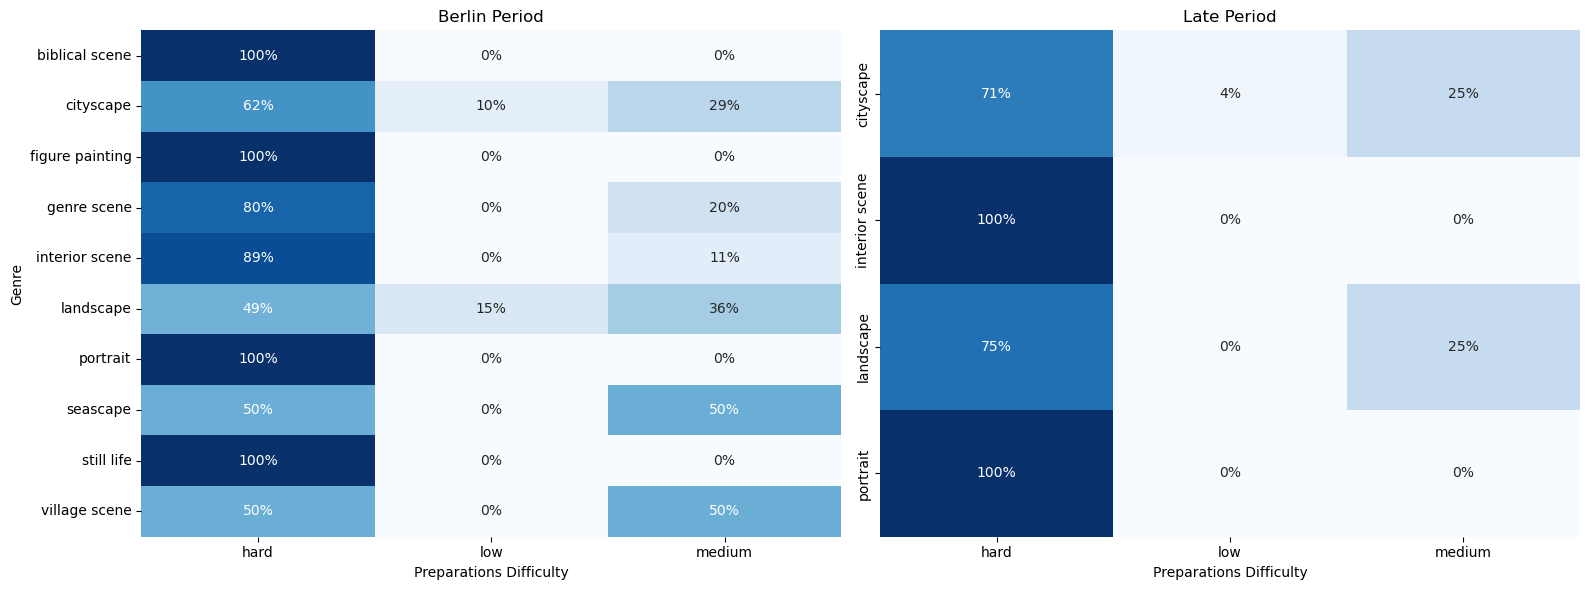

In [497]:
# making slice for Berlin period data
filtered_support_berlin = support.query('period == "Berlin period" and tech_group == "painting"').copy()

# creating the Berlin pivot table
pivot_table_berlin = filtered_support_berlin.pivot_table(index='genre',
                                                         columns=['preparations_difficulty'],
                                                         values='id',
                                                         aggfunc='count',
                                                         fill_value=0)

# calculating the share of the total amount by row
pivot_table_berlin_percentage = pivot_table_berlin.apply(lambda x: x / x.sum(), axis=1)

# applying the percent format to cells 
pivot_table_berlin_percentage_highlighted = pivot_table_berlin_percentage.style.format('{:.0%}')

#-----------------------------------------------------------------------------------------------------------------------

# making slice for Late period data
filtered_support_late = support.query('period == "Late period" and tech_group == "painting"').copy()

# creating the Late pivot table
pivot_table_late = filtered_support_late.pivot_table(index='genre',
                                                     columns=['preparations_difficulty'],
                                                     values='id',
                                                     aggfunc='count',
                                                     fill_value=0)

# calculating the share of the total amount by row
pivot_table_late_percentage = pivot_table_late.apply(lambda x: x / x.sum(), axis=1)

# applying the percent format to cells 
pivot_table_late_percentage_highlighted = pivot_table_late_percentage.style.format('{:.0%}')

#-----------------------------------------------------------------------------------------------------------------------

# making a gigure with two subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# define common MIN and MAX values for colorbar,  for comparable color representation
vmin = min(pivot_table_berlin_percentage.min().min(), pivot_table_late_percentage.min().min())
vmax = max(pivot_table_berlin_percentage.max().max(), pivot_table_late_percentage.max().max())

# making the heatmap for Berlin period
sns.heatmap(
    pivot_table_berlin_percentage,
    ax=axes[0],
    annot=True,
    fmt=".0%",
    cmap='Blues',
    vmin=vmin,
    vmax=vmax,
    cbar=False 
)
axes[0].set_title('Berlin Period')
axes[0].set_xlabel('Preparations Difficulty')
axes[0].set_ylabel('Genre')

# making the heatmap for Late period
sns.heatmap(
    pivot_table_late_percentage,
    ax=axes[1],
    annot=True,
    fmt=".0%",
    cmap='Blues',
    vmin=vmin,
    vmax=vmax,
    cbar=False 
)
axes[1].set_title('Late Period')
axes[1].set_xlabel('Preparations Difficulty')
axes[1].set_ylabel('')

# adjusting X-axis labels to prevent overlap
for ax in axes:
    plt.sca(ax)

# optimize the layout of elements
plt.tight_layout()
plt.show();


The Late period includes fewer genres, but this does not prevent comparison. In all of them, the share of paintings with hard preparation difficulty increases, which may indicate a more meticulous approach to creating artworks.

**Progress Update**

We found that most of Lesser Ury’s paintings were created on canvas. Does this mean it was his preferred support? Not necessarily. Our dataset includes only paintings that were sold, not his entire body of work. He may have created many pieces on other materials. Additionally, canvas is more durable over time compared to cardboard or watercolor paper, some of which may have been lost.

Still, among supports that require extensive preparation, canvas was the most common, accounting for 36% of the works. Panels and boards together make up only about 15%.

Paper ranks second, largely due to Ury’s strategy of producing prints. However, not all paper-based works were graphic prints—about 20% of them were created with pastels.

Cardboard comes in third and was the primary support for pastel works.

It is clear that Ury’s choice of support was closely tied to his technique. He used hard preparation difficulty materials like canvas, panels, and boards for more detailed, carefully executed paintings, especially those in oil. On the other hand, he experimented the most when working with pastels, using a wider variety of materials.

In summary:

**Canvas, wood panels, boards** – detailed, well-developed works.\
**Cardboard** – experiments and quick sketches.\
**Paper** – commercial projects.

## Dimensions

Okay, let's begin by obtaining the dimensions data.

In [498]:
# obtain the dimensions data 
dimension = df[['id', 'dimensions_h_w']].copy()
dimension.sample(5)

,id,dimensions_h_w
139,141,19.51 x 27
161,163,49.61 x 35.51
122,124,71 x 53
85,87,34.5 x 49.5
81,83,35 x 50


In [499]:
# find the dimensions variety
dimension['dimensions_h_w'].describe().T

count         181
unique        173
top       35 x 50
freq            4
Name: dimensions_h_w, dtype: object

We have 173 unique sizes out of 181 available, meaning 95% of the paintings have a unique size. Why so much variety?

First, orientation: sizes like 10×20 and 20×10 are counted as different, even though they are actually the same.\
Second, inconsistent measurement methods: some people recorded exact sizes down to the millimeter, while others rounded them.\
Finally, it’s unlikely that paintings were made with strict size standards—there were probably small variations.

To reduce this variety, I plan to round sizes to the nearest ten and always list the smaller side first.\
Let’s see what happens!

In [500]:
# extract the hight and width
dimension[['height', 'width']] = dimension['dimensions_h_w'].str.split('x', expand=True)
dimension['height'] = dimension['height'].astype(float)  # transform to float
dimension['width'] = dimension['width'].astype(float)    # transform to float


# round to the nearest 10
dimension['rounded_height'] = ((dimension['height'] + 5) // 10 * 10).replace(0, 10).astype(int)
dimension['rounded_width'] = ((dimension['width'] +5) // 10 * 10).replace(0, 10).astype(int)

# normalizing the sizes
dimension['normalized_dimensions'] = (
    dimension[['rounded_height', 'rounded_width']].min(axis=1).astype(str) + ' x ' +
    dimension[['rounded_height', 'rounded_width']].max(axis=1).astype(str)
)
dimension.sample(5)
print('-------------------------------------------------------------------------------------')
dimension['normalized_dimensions'].describe().T

,id,dimensions_h_w,height,width,rounded_height,rounded_width,normalized_dimensions
4,5,75 x 105,75.00,105.00,80,110,80 x 110
50,52,17.2 x 13.8,17.20,13.80,20,10,10 x 20
77,79,35.5 x 50.5,35.50,50.50,40,50,40 x 50
62,64,20.9 x 11.3,20.90,11.30,20,10,10 x 20
166,168,35.51 x 49.91,35.51,49.91,40,50,40 x 50


-------------------------------------------------------------------------------------


count         181
unique         27
top       40 x 50
freq           50
Name: normalized_dimensions, dtype: object

Great! We have reduced the number of unique sizes by a factor of 6—from 173 to 27. This will make the analysis much easier.

Let's look at the chart to see how the paintings are distributed by size.\
First, we need to consider that our dataset includes both paintings and graphic works. Graphic works are usually smaller unless they are posters or advertisements. Before analyzing, we'll add this characteristic to the data.

In [501]:
# add a paintings/graphic works label to the dataset
dimension = dimension.merge(technics[['id', 'tech_group']], on='id')

In [502]:
# gathering data.
normalized_dimensions_count = dimension.groupby(['normalized_dimensions', 'tech_group']).size().reset_index(name='count')

# landscape orientation is looking the default for me, therefore the first number is the height.
normalized_dimensions_count[['normalized_height', 'normalized_width']] = normalized_dimensions_count['normalized_dimensions']\
    .str.split('x', expand=True).astype(int)


# create the facet grid scatter plot
fig = px.scatter(normalized_dimensions_count,
                 x='normalized_width',
                 y='normalized_height',
                 size='count',
                 size_max=60,
                 facet_row='tech_group',
                 title="Distribution of <b style='color:rgba(255, 99, 71, 0.6)'> paintings</b> "
                     "and <b style='color:rgba(135, 206, 250, 0.6)'> graphic</b> works based on their normalized side dimensions.",
                 labels={'normalized_width': 'Rounded Width', 'normalized_height': 'Rounded Height'},
                 color = 'tech_group'
)

# set the color for backstage
fig.update_layout(
    plot_bgcolor='white',
    paper_bgcolor='white',
    title_x=0.5,
)

# the legend adds unnecessary visual noise - let's remove it
fig.update_layout(showlegend=False)

# changing the chart's size
fig.update_layout(
    height=1000,
    width=1000,
)

# show the chart
fig.show();

The chart confirmed the different size ranges for paintings and graphic works. Out of 27 normalized sizes, only 9 (one-third) appear in graphic works, while paintings feature 26. We see that for graphics, the height values range from 10 to 50, and the width values range from 10 to 70. For paintings, the height values are in a larger range from 10 to 90, and the width values range from 10 to 180 (twice as much). Although the graph does not provide a precise answer, I believe that the distribution of the sizes of the artworks is more uniform for graphics than for paintings.

Most common sizes (accounting for more than half of all works):

**Graphic works** (44 pieces):
- 10 × 20 — 10
- 20 × 20 — 11
- 30 × 50 — 8

**Paintings works** (137 pieces):
- 10 × 20 — 16
- 30 × 50 — 15
- 40 × 50 — 48
 
There is no clear leader among the graphic works, whereas in paintings, `40 × 50` dominates, appearing three times more frequently than the next most common size.

The IQR for the number of works gave an upper threshold of 16, which includes `10 × 20`. The size `40 × 50` is a statistical outlier in terms of frequency. This may indicate its special significance for the artist and, within our dataset, its role as the *primary format* for Uri’s paintings.

Ok. And now, let's analyze the orientation of paintings based on their type.

First, we'll determine how the height differs from the width. To start, we'll check if there are any paintings in the dataset with equal height and width.

In [503]:
# check if the height and width are equal
len(dimension.loc[dimension['height'] == dimension['width']])

0

Great, so we will have only two categories: `portrait` and `landscape`.

In [504]:
# determine the orientation of the artwork
dimension['orientation'] = np.where(dimension['height'] > dimension['width'], 'portrait', 'landscape')

In [505]:
# obtain the data
dimension.groupby(['orientation', 'tech_group']).size()

orientation  tech_group
landscape    graphic       10
             painting      80
portrait     graphic       34
             painting      57
dtype: int64

At first glance, the ratio of landscape to portrait orientation is 90 to 91, suggesting a random distribution. However, it's worth examining the difference between graphic and painting works.

For graphic works, there are only 10 landscape-oriented pieces compared to 34 portrait-oriented ones. This significant difference suggests that portrait orientation is dominant.

For paintings, there are 80 landscape-oriented works and 57 portrait-oriented ones. While landscape orientation appears more common, is this difference statistically significant? Can we confidently say that landscape is the preferred orientation for paintings?

To answer this, we will conduct a binomial test for both categories. This will help determine whether the distribution of landscape and portrait works is random, assuming an initial probability of 50% for each orientation.

In [506]:
# graphic works test (10 landscape, 34 portrait)
p_value_graphic = binomtest(10, 10+34, p=0.5, alternative='two-sided')

# painting works test (80 landscape, 57 portrait)
p_value_painting = binomtest(80, 80+57, p=0.5, alternative='two-sided')

print(f"P-value for graphic works: {p_value_graphic}")
print(f"P-value for painting works: {p_value_painting}")

P-value for graphic works: BinomTestResult(k=10, n=44, alternative='two-sided', statistic=0.22727272727272727, pvalue=0.00038813090293388086)
P-value for painting works: BinomTestResult(k=80, n=137, alternative='two-sided', statistic=0.583941605839416, pvalue=0.05976798194970618)


Great!\
We have determined that at a significance level of 0.05, the distribution of landscape and portrait orientations in paintings appears random (P-value = 0.0597).

We also confirmed our initial assumption that the distribution of orientations in graphic works is far from random (P-value = 0.00039). But what could be causing this?

I can see at least two possible factors:
- **Technique** – certain technical aspects might influence orientation choices.
- **Genre** – some genres, like portraits, are naturally associated with portrait orientation.

Let's add the necessary data to our dataset and see if this holds true.

In [507]:
# enriching the dataset by 'technique' and 'genre'
dimension = dimension.merge(technics[['id', 'technique']], on = 'id').merge(genre[['id', 'genre']], on = 'id')
dimension.head()

,id,dimensions_h_w,height,width,rounded_height,rounded_width,normalized_dimensions,tech_group,orientation,technique,genre
0,1,80 x 100,80.0,100.0,80,100,80 x 100,painting,landscape,oil,cityscape
1,2,70 x 90,70.0,90.0,70,90,70 x 90,painting,landscape,oil,cityscape
2,3,60 x 80,60.0,80.0,60,80,60 x 80,painting,landscape,oil,landscape
3,4,90 x 120,90.0,120.0,90,120,90 x 120,painting,landscape,oil,genre scene
4,5,75 x 105,75.0,105.0,80,110,80 x 110,painting,landscape,oil,interior scene


Now, let's create two heatmaps and compare which techniques and genres were the most significant.

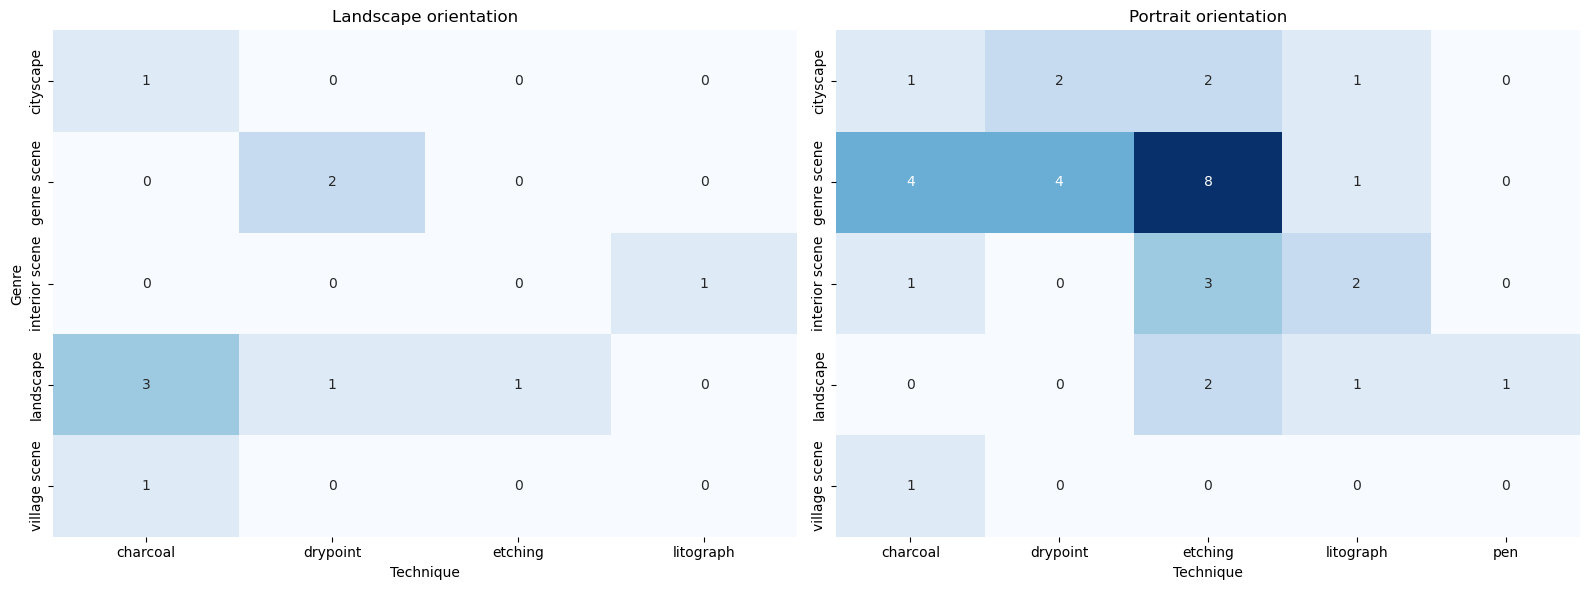

In [508]:
# making slice for graphic group, landscape oriented works
filtered_dimension_landscape = dimension.query('tech_group == "graphic" and orientation == "landscape"').copy()

# creating the landscape pivot table
pivot_table_landscape = filtered_dimension_landscape.pivot_table(index='genre',
                                                         columns=['technique'],
                                                         values='id',
                                                         aggfunc='count',
                                                         fill_value=0)

#-----------------------------------------------------------------------------------------------------------------------

# making slice for graphic group, portrait oriented works
filtered_dimension_portrait = dimension.query('tech_group == "graphic" and orientation == "portrait"').copy()

# creating the Late pivot table
pivot_table_portrait = filtered_dimension_portrait.pivot_table(index='genre',
                                                     columns=['technique'],
                                                     values='id',
                                                     aggfunc='count',
                                                     fill_value=0)

#-----------------------------------------------------------------------------------------------------------------------

# making a figure with two subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# define common MIN and MAX values for colorbar,  for comparable color representation
vmin = min(pivot_table_landscape.min().min(), pivot_table_portrait.min().min())
vmax = max(pivot_table_landscape.max().max(), pivot_table_portrait.max().max())

# making the heatmap for landscape orientation
sns.heatmap(
    pivot_table_landscape,
    ax=axes[0],
    annot=True,
    fmt=".0f",
    cmap='Blues',
    vmin=vmin,
    vmax=vmax,
    cbar=False 
)
axes[0].set_title('Landscape orientation')
axes[0].set_xlabel('Technique')
axes[0].set_ylabel('Genre')

# making the heatmap for portrait orientation
sns.heatmap(
    pivot_table_portrait,
    ax=axes[1],
    annot=True,
    fmt=".0f",
    cmap='Blues',
    vmin=vmin,
    vmax=vmax,
    cbar=False 
)
axes[1].set_title('Portrait orientation')
axes[1].set_xlabel('Technique')
axes[1].set_ylabel('')

# adjusting X-axis labels to prevent overlap
for ax in axes:
    plt.sca(ax)

# optimize the layout of elements
plt.tight_layout()
plt.show();

The winners are immediately noticeable: **genre scene** and **etching** technique. However, let's take a closer look at the distributions before drawing final conclusions.

First, let's excluding non-representative data.\
Some categories have too few observations to be statistically significant. According to the binomial test, when one variable has a count of 1, the other must be at least 8 to detect significant differences. Therefore, we exclude the following:

- *cityscape* (1/6)
- *interior scenes* (1/6)
- *village scenes* (1/1)
- *lithograph* technique (1/5)

Now, let's examine the genres and techniques with a sufficient number of observations:

- genre *landscape* (5/4) – the ratio is almost 50/50, indicating a random choice of orientation. We exclude this category from further analysis.
- genre *genre scene* (2/17) – a significant difference between landscape and portrait orientation. This appears to be a systematic trend, but we will confirm it with a binomial test.
- technique *charcoal* (5/7) – the ratio is close to 50/50, suggesting a random orientation choice. We exclude this technique.
- technique *drypoint* (3/6) – a slight preference for portrait orientation, but not strong enough to draw conclusions without further testing. We will conduct a binomial test.
- technique *etching* (1/15) – the difference is too large to be random. There is no need for a test—the orientation is clearly determined by non-random factors.

Alright, let's proceed with binomial tests for the *genre scene* and *drypoint* technique to verify the null hypothesis of random orientation distribution.

In [509]:
# drypoint tehnique works test (3 landscape, 6 portrait)
p_value_drypoint = binomtest(3, 3+6, p=0.5, alternative='two-sided')

# genre scene works test (2 landscape, 17 portrait)
p_value_genre_scene = binomtest(2, 2+17, p=0.5, alternative='two-sided')

print(f"P-value for drypoint works: {p_value_drypoint}")
print(f"P-value for genre scene works: {p_value_genre_scene}")

P-value for drypoint works: BinomTestResult(k=3, n=9, alternative='two-sided', statistic=0.3333333333333333, pvalue=0.5078125)
P-value for genre scene works: BinomTestResult(k=2, n=19, alternative='two-sided', statistic=0.10526315789473684, pvalue=0.000728607177734375)


*P-value for the drypoint technique* (0.5078) is significantly above the 0.05 significance level, meaning we have no grounds to reject the null hypothesis. This indicates that the choice of orientation for this technique was random.

However, *P-value for the 'genre scene'* category (0.0007) suggests otherwise—here, orientation was clearly not chosen randomly. It is likely that one orientation was deliberately preferred by the artist in this genre.

So, we have two factors influenced the choice of orientation for graphic works:
- **etching** technique
- **genre scene** category

Other genres and techniques did not show statistically significant differences in orientation distribution.

Ok, we have examined orientation, but what about size? Could the dimensions of a painting influence the choice of orientation?
Now, let's classify paintings by size to see how their distribution changed depending on different factors.

Where do we start? Since I will be using value ranges for classification, there is no need to work with exact dimensions—I will use rounded values instead.

As a basis, I am using the criteria proposed by the website from which I obtained most of the data (www.artsy.net):

- **small**: if the larger side is up to 30 cm.
- **medium**: if the larger side is up to 70 cm.
- **large**: if the larger side is more than 70 cm.

However!\
During my initial review of the data, I noticed that some paintings have one side as small as 10 cm or even less. Even if the other side is significantly larger, such dimensions seem extremely small to me. Therefore, I am introducing an additional **'mini'** category for these cases. This is not part of the market classification but rather my own adaptation based on the specifics of the dataset.

Although graphic works are usually smaller than paintings, I will not introduce a separate classification for them to avoid unnecessary complexity. Instead, during the analysis, we will consider the following:

- **mini** – approximately the size of a **postcard** (up to 10 cm).
- **small** – comparable to a **sketchbook page** (up to 30 cm).
- **medium** – about the size of a **poster** (up to 70 cm).

Alright, let's get started.

In [510]:
# create a classification function
def classify_artwork_size(df):
    """
    Classifies artworks into size categories (mini, small, medium, large)
    based on their rounded height and width.

    This function adds a new 'size_category' column to the input DataFrame.
    The categorization logic is applied row-wise, considering the maximum
    dimension (height or width) for 'small', 'medium', and 'large',
    with a special condition for 'miniature' size.

    :param df: A Pandas DataFrame expected to contain 'rounded_height' and 'rounded_width' columns.
    :return: The DataFrame with an added 'size_category' column.
    """

    def categorize_size(row):
        """
        Helper function to determine the size category for a single artwork.

        The categorization is based on predefined thresholds for 'rounded_height'
        and 'rounded_width' from the DataFrame row.

        :param row: A Pandas Series representing a single row of the DataFrame,
                    containing 'rounded_height' and 'rounded_width'.
        :return: A string indicating the size category ('mini', 'small', 'medium', 'large').
        """
        height = row['rounded_height']
        width = row['rounded_width']

        if height == 10 or width == 10:  # first, check the condition for "miniature"
            return 'mini'
        elif max(height, width) <= 30:
            return 'small'
        elif max(height, width) <= 70:
            return 'medium'
        else:
            return 'large'

    df['size_category'] = df.apply(categorize_size, axis=1)
    return df

# classify the art works
dimension = classify_artwork_size(dimension)
dimension.sample(5)

,id,dimensions_h_w,height,width,rounded_height,rounded_width,normalized_dimensions,tech_group,orientation,technique,genre,size_category
55,57,50.5 x 35.5,50.50,35.50,50,40,40 x 50,painting,portrait,pastel,landscape,medium
144,146,10.21 x 7.01,10.21,7.01,10,10,10 x 10,graphic,portrait,etching,interior scene,mini
161,163,49.61 x 35.51,49.61,35.51,50,40,40 x 50,graphic,portrait,pen,landscape,medium
149,151,35.2 x 50.01,35.20,50.01,40,50,40 x 50,painting,landscape,pastel,cityscape,medium
180,182,43.18 x 33.02,43.18,33.02,40,30,30 x 40,painting,portrait,oil,cityscape,medium


Great, now let's visualize the distribution.

In [511]:
# gathering data.
size_category_count = dimension.groupby(['size_category', 'tech_group']).size().reset_index(name='count')

# define the order of categories
category_order = ['mini', 'small', 'medium', 'large']

# define the order of tech_group
tech_group_order = ['graphic', 'painting']

# create the facet grid bar plot
fig = px.bar(size_category_count,
                 x='size_category',
                 y='count',
                 facet_row='tech_group',
                 title="Distribution of <b style='color:rgba(135, 206, 250, 0.6)'> graphic</b> "
                     "and <b style='color:rgba(255, 99, 71, 0.6)'> paintings</b> works based on size categorys.",
                 labels={'size_category': 'Size Category', 'count': 'Number of Works'},
                 color = 'tech_group',
                 category_orders={'size_category': category_order, 'tech_group': tech_group_order}
)

# set the color for backstage
fig.update_layout(
    plot_bgcolor='white',
    paper_bgcolor='white',
    title_x=0.5,
)

# the legend adds unnecessary visual noise - let's remove it
fig.update_layout(showlegend=False)

# the number of works varies significantly between technique groups, so it's better to use independent y-axis scales
fig.update_yaxes(matches=None)

# changing the chart's size
fig.update_layout(
    height=1000,
    width=950,
)

# show the chart
fig.show();

Graphical works are distributed across three main size categories, which we can label as **postcard**, **album sheet**, and **poster**. All pieces are unique and are not replicated in multiple formats. The distribution across these categories is relatively balanced, with 12, 16, and 16 works respectively. This suggests that the artist selects the format for each graphic piece based on creative intent, without a strong preference for a particular size.

Painting works fall into four size categories: **miniature**, **small**, **medium**, and **large**. In this case, the distribution is clearly skewed toward the medium size, which accounts for more than half of the paintings (81 out of 137 total). *This indicates that medium format is Uri’s preferred choice for painting*. The other categories — miniatures, small, and large formats — appear less frequently and may reflect specific genre or technical considerations.

Now, let’s take a closer look at the graphical works to analyze how their size choices align with technique, subject matter, and overall creative approach.

In [512]:
# create separate pivot tables to display the distribution of works by genre and by technique

print('Distribution by genre')
dimension.loc[dimension['tech_group'] == 'graphic'].pivot_table(index='size_category',
                                                         columns=['genre'],
                                                         values='id',
                                                         aggfunc='count',
                                                         fill_value=0)
print('\n -------------------------------------------------------------------------------------------\n')
print('Distribution by technique')
dimension.loc[dimension['tech_group'] == 'graphic'].pivot_table(index='size_category',
                                                         columns=['technique'],
                                                         values='id',
                                                         aggfunc='count',
                                                         fill_value=0)

Distribution by genre


genre,cityscape,genre scene,interior scene,landscape,village scene
size_category,,,,,
medium,2,5,2,5,2
mini,2,7,2,1,0
small,3,7,3,3,0



 -------------------------------------------------------------------------------------------

Distribution by technique


technique,charcoal,drypoint,etching,litograph,pen
size_category,,,,,
medium,11,0,1,3,1
mini,0,4,8,0,0
small,1,5,7,3,0


We’re looking at five genres: *cityscape, genre scene, interior scene, landscape,* and *village scene*.

In terms of genre distribution, *miniature-sized* works are most commonly found in the **genre scene** category - 7 out of 12. The same genre also leads in the *small size* category - 7 out of 16. For *medium-sized* works, there’s a tie between **genre scene** and **landscape** — each with 5 out of 16. So overall, **genre scene appears to be the most size-flexible genre**, showing up consistently across all format categories.

Now let’s look at technique distribution. The available techniques include: *charcoal, drypoint, etching, lithograph*, and *pen*.

When it comes to *miniature* and *small* formats, **etching** dominates - with 8 and 7 works respectively. This technique allows for a high level of detail, which works well with smaller canvas sizes.
For *medium* formats, the most frequently used technique is **charcoal** - with 11 out of 16. Charcoal is better suited for bold lines and tonal contrast, which likely benefits from a larger surface area.

Based on this, a few patterns emerge:

- Genre and size seem correlated. Genre scene, cityscape, and interior scene show up across all size categories, suggesting they’re more format-agnostic.
- Some genres may require more space. Village scenes are only present in the medium size category - possibly due to the need for more layout space to show detail.
- Technique choice appears size-dependent. Charcoal and lithograph are mostly used in medium-sized works, likely because they support expressive strokes and shading. Meanwhile, etching and drypoint are more versatile, especially effective in mini and small formats.
- Smaller formats often require more precision. Despite their size, miniatures tend to be done in more complex techniques like etching and drypoint - indicating a focus on fine detail rather than speed or simplicity.

All in all, it seems that *Lesser Ury’s choice of artwork size was quite deliberate*. He likely considered not just the subject and medium, but also how these elements would work together. In this case, **size functions as an intentional design parameter** - not just a practical constraint.

With that in mind, let's move on to Ury's works created in painting techniques.

In [513]:
# create separate pivot tables to display the distribution of works by genre and by technique

print('Distribution by genre')
dimension.loc[dimension['tech_group'] == 'painting'].pivot_table(index='size_category',
                                                         columns=['genre'],
                                                         values='id',
                                                         aggfunc='count',
                                                         fill_value=0)

print('\n -------------------------------------------------------------------------------------------\n')
print('Distribution by technique')
dimension.loc[dimension['tech_group'] == 'painting'].pivot_table(index='size_category',
                                                         columns=['technique'],
                                                         values='id',
                                                         aggfunc='count',
                                                         fill_value=0)

Distribution by genre


genre,biblical scene,cityscape,figure painting,genre scene,interior scene,landscape,portrait,seascape,still life,village scene
size_category,,,,,,,,,,
large,1,8,1,4,2,10,0,0,2,1
medium,0,28,0,1,5,35,2,4,1,5
mini,0,10,0,2,2,3,0,0,0,1
small,1,4,0,1,1,2,0,0,0,0



 -------------------------------------------------------------------------------------------

Distribution by technique


technique,oil,pastel,watercolor
size_category,,,
large,26,3,0
medium,27,53,1
mini,17,1,0
small,7,2,0


The painting dataset includes works across all 10 genres:
*biblical scene, cityscape, figure painting, genre scene, interior scene, landscape, portrait, seascape, still life*, and *village scene*.

When we look at smaller size categories — *mini and small* — **cityscape** clearly dominates (10 and 4 pieces, respectively). For *medium* and *large* sizes, **landscape** takes the lead (35 and 10), suggesting this genre benefits from more canvas space.

Now let’s break down by technique. The dataset includes *oil, pastel*, and *watercolor*.\
**Oil** is the most commonly used across *mini*, *small*, and *large* paintings (17, 27, 26), while **pastel** peaks in the *medium* category with 53 works. Watercolor appears just once — a clear outlier.

Based on this, several patterns emerge:

- Bigger canvas, bigger space. Spatial genres like *landscape* and *cityscape* tend to appear more in medium and large formats, which supports the idea that they need space to show depth. *Village* scene, on the other hand, is mainly in the medium size — likely due to the detail required.
- Cityscape is the most flexible genre, found across all size categories, making it the most size-agnostic in the dataset.
- Detail-heavy genres prefer smaller formats. Genres like *genre scene* and *interior scene* are spread across mini, small, and medium categories. These types of scenes focus on subtle human interactions and interior details, which don’t require large space.
- Interestingly, biblical scenes appear only in small and large sizes. WHy? Is there a specific genre created solely for commissions?.
- Technique selection is size-dependent. Oil is dominant in larger works, which makes sense given its richness and textural qualities. Pastel, with its soft detail, is mostly used in medium-sized pieces — perhaps due to practical handling and expressive potential at that scale.

All in all, the data suggests that Lesser Ury’s choices around genre, technique, and size weren’t random. His choices of size, subject, and medium clearly reflect a thoughtful and intentional process

Ok, time to found out which of Ury’s paintings may have been commissioned.
To start, we’ll focus only on painted works. As we know, most of the graphic works were created using reproducible techniques — such as etching, lithography, and drypoint — where the concept of *commissioned work* is less relevant.\
And to be honest, I’m more interested in his paintings anyway.

The first potential indicator of a commissioned work is **size**.
From the data, we know that medium-sized works were most common among the paintings, so we'll treat them as the baseline - the default, not indicative of a commission.\
That leaves us with three other categories:

**Large paintings** - it's unlikely an artist chooses this format spontaneously, unless it’s their default style. So this may signal a special request.

**Miniatures** - an unusual, very specific format. These could be personal gifts or small private commissions.

**Small works** - we’ll keep them as regular size variations, not particularly indicative on their own.

Of course, we can’t label all large or miniature works as commissioned by default. Artists experiment - and Ury certainly did, as seen in his use of diverse genres and techniques.\
That’s why I propose a second feature: **aspect ratio**.\
Paintings created for a specific space (a niche, a panel, a certain wall) might have a unique or non-standard shape — unusually tall, wide, or square. That could be a strong clue for a custom commission.

The third feature is **rarity of size**.\
We won’t use exact dimensions (there are 173 unique values across 181 works — too granular). Instead, we’ll round dimensions to the nearest 10 cm and flag the sizes that appear only once or twice.\
If the rounded size is rare, it could indicate a piece tailored to a specific need.

We’ll assign one point for each positive feature:

- if the work `is a miniature`
- if the work `is large`
- if it `has a non-standard aspect ratio`
- if it `has a rare (rounded) size`

Each work can earn up to 3 points (since a painting can’t be both large and miniature).\
Finally, we’ll treat paintings with the maximum score as likely commissioned.

Ok, hit the road.

In [514]:
# get the feature 'is_miniature'
dimension['is_miniature'] = np.where(
    dimension['size_category'] == 'mini', 1, 0)
# get the feature 'is_large'
dimension['is_large'] = np.where(
    dimension['size_category'] == 'large', 1, 0)

Our next step is to identify abnormal aspect ratio sizes. We'll begin by looking at some statistics.

In [515]:
# obtain the 'aspect ratio' values
dimension['aspect_ratio'] = dimension['height']/dimension['width']

# get the statistics of aspect ratio
dimension.loc[dimension['tech_group'] == 'painting']['aspect_ratio'].describe().T
dimension.loc[dimension['tech_group'] == 'painting']['aspect_ratio'].mode()

count    137.000000
mean       1.016033
std        0.396483
min        0.448505
25%        0.702970
50%        0.777778
75%        1.389189
max        2.022222
Name: aspect_ratio, dtype: float64

0    0.700000
1    0.727273
Name: aspect_ratio, dtype: float64

Based on the data, the median aspect ratio is 0.77, suggesting that horizontal compositions are slightly more common.\
Attempting to apply the interquartile range (IQR ≈ 0.69) to identify outliers doesn’t yield meaningful results — the calculated bounds don’t intersect with the actual minimum and maximum values.\
Therefore, instead of relying purely on statistical thresholds, it makes sense to also consider the context.

Looking at the distribution, the most common aspect ratios fall between 0.7 and 1.3.\
I propose treating this range as the "standard" aspect ratio for canvas paintings.\
Works with a ratio above 1.3 can be classified as vertically elongated (non-standard), while those with a ratio below 0.6 are excessively horizontal.

In [516]:
# define the conditions of bounds
conditions = [
    (dimension['aspect_ratio'] > 1.3),
    (dimension['aspect_ratio'] < 0.6)
]

# set the values when their conditions are met
values = [1, 1]

# get the feature 'is unusual ratio'
dimension['is_unusual_ratio'] = np.select(conditions, values, default=0)

Okay, and finally, the rare normalized dimensions.

In [517]:
# first, computing the frequency of each dimension.
rare_sizes = dimension['normalized_dimensions'].value_counts()
rare_sizes = rare_sizes[rare_sizes <= 2].index  # only dimensions with a frequency of 2 or less remained

# get the feature 'is_rare_size'
dimension['is_rare_size'] = dimension['normalized_dimensions'].isin(rare_sizes).astype(int)

# show the result
dimension.sample(10)

,id,dimensions_h_w,height,width,rounded_height,rounded_width,normalized_dimensions,tech_group,orientation,technique,genre,size_category,is_miniature,is_large,aspect_ratio,is_unusual_ratio,is_rare_size
119,121,16 x 10,16.00,10.00,20,10,10 x 20,graphic,portrait,drypoint,genre scene,mini,1,0,1.600000,1,0
50,52,17.2 x 13.8,17.20,13.80,20,10,10 x 20,graphic,portrait,drypoint,cityscape,mini,1,0,1.246377,0,0
79,81,36 x 49,36.00,49.00,40,50,40 x 50,painting,landscape,pastel,landscape,medium,0,0,0.734694,0,0
179,181,35.56 x 48.26,35.56,48.26,40,50,40 x 50,painting,landscape,pastel,landscape,medium,0,0,0.736842,0,0
41,43,50.1 x 31.7,50.10,31.70,50,30,30 x 50,graphic,portrait,charcoal,village scene,medium,0,0,1.580442,1,0
34,36,23.2 x 16.8,23.20,16.80,20,20,20 x 20,graphic,portrait,drypoint,cityscape,small,0,0,1.380952,1,0
27,28,36.8 x 50.5,36.80,50.50,40,50,40 x 50,painting,landscape,pastel,landscape,medium,0,0,0.728713,0,0
100,102,49.4 x 34.8,49.40,34.80,50,30,30 x 50,painting,portrait,pastel,cityscape,medium,0,0,1.419540,1,0
115,117,97 x 67,97.00,67.00,100,70,70 x 100,painting,portrait,oil,landscape,large,0,1,1.447761,1,0
44,46,49.7 x 35.7,49.70,35.70,50,40,40 x 50,painting,portrait,pastel,cityscape,medium,0,0,1.392157,1,0


In [518]:
# ok, let's get the 'custom score' column, finally
dimension['custom_score'] = dimension[['is_miniature', 'is_large', 'is_unusual_ratio', 'is_rare_size']].sum(axis=1)

In [519]:
# count commissioned works
commissioned_works = dimension.loc[dimension['custom_score'] == 3]
commissioned_works.shape[0]
commissioned_works

7

,id,dimensions_h_w,height,width,rounded_height,rounded_width,normalized_dimensions,tech_group,orientation,technique,genre,size_category,is_miniature,is_large,aspect_ratio,is_unusual_ratio,is_rare_size,custom_score
10,11,100.5 x 52,100.50,52.00,100,50,50 x 100,painting,portrait,oil,genre scene,large,0,1,1.932692,1,1,3
11,12,94 x 176,94.00,176.00,90,180,90 x 180,painting,landscape,oil,figure painting,large,0,1,0.534091,1,1,3
36,38,105.3 x 59.3,105.30,59.30,110,60,60 x 110,painting,portrait,oil,genre scene,large,0,1,1.775717,1,1,3
51,53,13.5 x 30.1,13.50,30.10,10,30,10 x 30,painting,landscape,oil,genre scene,mini,1,0,0.448505,1,1,3
133,135,77.8 x 46.99,77.80,46.99,80,50,50 x 80,painting,portrait,oil,still life,large,0,1,1.655671,1,1,3
146,148,87 x 53.49,87.00,53.49,90,50,50 x 90,painting,portrait,oil,landscape,large,0,1,1.626472,1,1,3
148,150,115.49 x 85.39,115.49,85.39,120,90,90 x 120,painting,portrait,oil,landscape,large,0,1,1.352500,1,1,3


In [520]:
# let's check which genre these work are
commissioned_works.groupby('genre').size(
    ).reset_index(name = 'number_of_works'
                 ).sort_values(by = 'number_of_works', ascending = False)

,genre,number_of_works
1,genre scene,3
2,landscape,2
0,figure painting,1
3,still life,1


We identified 7 potential commissioned works out of 137 paintings — that's only about 5%.\
Interestingly, the most common genre among these was genre scenes, rather than landscapes or cityscapes, as one might expect.\
Another surprising point: portraits — a genre I definitely expected to see — didn’t make the list at all.\
Maybe it would have made sense to treat portraits as a separate, unconditional marker for commissioned work, but even if we did, the total would only rise to 9 pieces.\
Overall, this suggests that Uri generally preferred more free, independent creativity over working on commission.

## Progres Update

In this section, we analyzed 181 available artworks by Ury, of which 173 had recorded dimensions. Initially, we observed high variability in sizes, caused both by differences in artwork orientation and inconsistencies in data recording. To normalize the dataset, we rounded dimensions to the nearest 10 cm and standardized the format as smaller side × larger side. This process reduced the number of unique size entries by 6 times — from 173 to 27.

Since paintings and graphic works naturally differ in size range, we analyzed them separately. Graphic works showed a more compact size range (height 10–50 cm, width 10–70 cm), while paintings tended to be larger (height 10–90 cm, width 10–180 cm). Among graphic works, no dominant size was identified. In contrast, paintings showed a clear peak around the 40×50 cm format, significantly more frequent than other sizes, suggesting it may have been Uri’s standard size for paintings.

We also examined artwork orientation. Overall, the distribution between landscape and portrait orientations was almost even (90 vs 91 works). However, when broken down by technique, clear patterns emerged: in graphic works, portrait orientation was much more common (34 vs 10), while in paintings, landscape orientation prevailed (80 vs 57), although the difference was not statistically significant. Further analysis showed that within graphic works, portrait orientation was particularly associated with the etching technique and genre scenes.

Next, we grouped artwork sizes into four categories — miniatures, small, medium, and large — to simplify the analysis. This revealed that for graphic works, distribution across miniature, small, and medium sizes was fairly balanced, while for paintings, the "medium" category clearly dominated (81 out of 137 works).

In the final stage, we aimed to identify potential commissioned works by applying criteria such as specific dimensions, aspect ratio, and rarity of size occurrence. Initially, we identified 7 such works, most of which were genre scenes (while landscape and cityscape are the overall leading genres). After further review, we expanded the list to 9 works by adding two portraits. This adjustment is consistent with the understanding that portraits are often commissioned (excluding self-portraits, which were not relevant here).

In summary: Ury explored a wide range of sizes in his artistic practice, but our analysis indicates that these choices were not random. He selected formats thoughtfully, adapting size to the genre, technique, and compositional needs. For instance, etchings of genre scenes were often created in smaller, portrait-oriented formats, emphasizing the intimacy of the subject. Meanwhile, paintings of landscapes and cityscapes favored medium and large landscape-oriented formats, which better conveyed spatial depth and dynamic scenes. Size and orientation thus served as deliberate expressive tools in Ury’s creative process.

# Title

So, moving from the simple to the more complex, we’ve arrived at the titles of Ury’s paintings. We’ll try to understand whether he preferred short, open-ended titles that left room for interpretation, or if he used them to clearly define what he wanted to show on the canvas. We’ll look at how his naming style changed over time, how emotionally charged the titles were, and - if possible - identify locations that held particular meaning for him or to which he returned often.\
Let’s dive in.

In [521]:
# obtain the titles data 
titles = df[['id', 'title']].copy()
titles.sample(5)

,id,title
165,167,Holländisches Dorf am Kanal mit Windmühle im H...
175,177,Sonnenuntergang am Grunewaldsee
85,87,Blick auf die Konditorei Moritz Dobrin in der ...
82,84,Landschaft mit Windmühle
120,122,Straße Bei Nacht im Regen (Berlin)


First, let's standardize all words and remove unnecessary symbols and extra spaces.

In [522]:
# create a function to clean the text
def clean_text(text):
    """ 
     Cleans a given string by converting it to lowercase and removing special characters.

    This function is designed to preprocess text, typically for natural language processing (NLP)
    tasks, by normalizing its case and stripping out punctuation or numbers,
    while preserving common German umlauts and 'ß'.

    :param text: The input string to be cleaned.
    :return: The cleaned string in lowercase, containing only alphabetic characters (a-z, ä, ö, ü, ß) and spaces.
    """
    text = text.lower()
    text = re.sub(r'[^a-zäöüß\s]', '', text)
    return text

# applay the 'clean_text' function 
titles['clean_title'] = titles['title'].apply(clean_text)

Let’s start with something simple - checking how many unique titles we have and whether there are any duplicates. True, we already ran a basic check at the beginning and didn’t find any obvious repetitions. But now we’re looking for subtler cases: for example, when the same title appears with different combinations of uppercase and lowercase letters.

In [523]:
# find the number of unique titles
print(f"Number of unique titles: {titles['clean_title'].nunique()}")

# find the duplicate titles
duplicate_titles = titles[titles.duplicated('title', keep=False)].sort_values('title')
print("\n"f"{duplicate_titles.shape[0]} works have duplicate titles:")
print("\n".join(duplicate_titles[['id', 'title']]))

Number of unique titles: 180

0 works have duplicate titles:
id
title


Lovely, no duplicates. Now, let's explore the statistics.

In [524]:
# get average title length (in symbols)
titles['title_length_chars'] = titles['clean_title'].apply(len)
average_length_chars = titles['title_length_chars'].mean()
print(f"Average title length (in symbols): {average_length_chars:.0f}")

# get average title length (in words)
titles['title_length_words'] = titles['clean_title'].apply(lambda x: len(x.split()))
average_length_words = titles['title_length_words'].mean()
print(f"Average title length (in words): {average_length_words:.0f}")

# find the shortest and longest titles (by symbols number)
min_length = titles['title_length_chars'].min()
max_length = titles['title_length_chars'].max()

shortest_titles = titles[titles['title_length_chars'] == min_length]['title'].tolist()
longest_titles = titles[titles['title_length_chars'] == max_length]['title'].tolist()

print(f"The shortest title ({min_length} symbols): {shortest_titles}")
print(f"The longest title ({max_length} symbols): {longest_titles}")

# find the shortest and longest titles by words number
min_words = titles['title_length_words'].min()
max_words = titles['title_length_words'].max()

shortest_titles_words = titles[titles['title_length_words'] == min_words]['title'].tolist()
longest_titles_words = titles[titles['title_length_words'] == max_words]['title'].tolist()

print(f"The titles with the fewest words ({min_words} words): {shortest_titles_words}")
print(f"The titles with the most words ({max_words} words): {longest_titles_words}")

Average title length (in symbols): 29
Average title length (in words): 4
The shortest title (7 symbols): ['Devorah', 'München']
The longest title (92 symbols): ['Berliner Straßenmotiv mit Automobilen und Alleebäumen, links Reitweg mit Reiter und Fußgänger']
The titles with the fewest words (1 words): ['Caféhausszene', 'Amaryllis', 'Selbstbildnis', 'Strassenszene', 'Devorah', 'Versammlungssaal', 'Herbstallee', 'München']
The titles with the most words (12 words): ['Blick auf die Konditorei Moritz Dobrin in der Lennéstraße 1 im Tiergarten, Berlin', 'Berliner Straßenmotiv mit Automobilen und Alleebäumen, links Reitweg mit Reiter und Fußgänger']


So, we’ve got some numbers that might seem a bit contradictory at first glance. On average, each title has 29 characters and 4 words. Now, if there are 4 words, that means there are 3 spaces between them — leaving us with 26 characters for the words themselves. That gives an average word length of about 6.5 characters.

And that raises a question: isn’t that a bit short for the German language? According to research published on [ResearchGate](https://www.researchgate.net/figure/Distributions-of-phonological-word-lengths-for-Dutch-English-French-German-and_fig7_230724353), the average length of a German word is about 8 to 9 characters. That’s largely due to the language’s love for compound words — long, packed, and efficient.

So, did Ury use some kind of special, unusually short vocabulary?

Probably not. The explanation is likely much simpler. German is full of short function words — articles, prepositions, conjunctions — like der, am, im, mit. These show up frequently in titles and naturally bring the average word length down. It’s these little words that “pull the average to the left.”

Now let’s see how the length and structure of his titles changed over time — will we spot the same effect there?

In [525]:
# first, let's retrieve the data by year
titles = titles.merge(df[['id', 'year']], on='id')
titles.sample(3)

,id,title,clean_title,title_length_chars,title_length_words,year
162,164,"Galerie im Café Vaterland am Potsdamer Platz, ...",galerie im caf vaterland am potsdamer platz be...,50,8,1920
11,12,Lying Nude,lying nude,10,2,1889
93,95,"Allee Im Tiergarten, Berlin",allee im tiergarten berlin,26,4,1920


In [526]:
# next, , calculate the average number of words in titles by years
avg_len_titles_words = titles.groupby('year')['title_length_words'].mean().reset_index(name = 'avg_len')

# now to find the average number of characters per word
# i'll calculate the total number of characters in the titles (excluding spaces)
titles['title_length_chars_no_spaces'] = titles['clean_title'].apply(lambda x: len(x.replace(" ", "")))

# and finaly, computing average number of characters per word, without spaces
titles['chars_per_word'] = titles['title_length_chars_no_spaces'] / titles['title_length_words']

# calculate the average number of characters per word (excluding spaces) across years
avg_len_titles_chars_per_word = titles.groupby('year')['chars_per_word'].mean().reset_index(name = 'avg_len_symbols')

# and now, let's make the line plot with words number
fig = px.line(avg_len_titles_words, 
             x = 'year', 
             y = 'avg_len', 
             title = "How long were Ury’s titles - and his words?"
              "<br><i>As titles get heavier, words slim down.</i>",
             labels = {"year": "year", "avg_len": "avg number of <b style='color:lightblue'> words </b>"
                      "/<b style='color:peachpuff'>characters per word </b>"},
             color_discrete_sequence = ['lightblue']) 

# add next lineplot with average characters per word
fig.add_trace(px.line(avg_len_titles_chars_per_word,
                      x='year',
                      y='avg_len_symbols',
                      labels={"year": "year", "avg_len_symbols": "average number characters per word"},
                      color_discrete_sequence = ['peachpuff']
                     ).data[0])

# set the color for backstage
fig.update_layout(
    plot_bgcolor = 'white',
    paper_bgcolor = 'white',
    title_x = 0.5,  
)

# adding the line for the average value of words number
mean_value = np.round(avg_len_titles_words['avg_len'].mean(), 0)
fig.add_shape(type = "line", 
              x0 = 1878, 
              y0 = mean_value, 
              x1 = 1929, 
              y1 = mean_value, 
              line = dict(color = "lightgray", width = 2, dash = "dash"))

# adding a lable for the average number of characters per word
fig.add_annotation(x = 1883, 
                   y = mean_value + 0.5, 
                   text = f'Average words number ({mean_value:.0f})', 
                   showarrow = False,  
                   font = dict(color = 'gray'))

# adding a label for the max value of words number
max_value = avg_len_titles_words['avg_len'].max()
max_year = avg_len_titles_words.loc[avg_len_titles_words['avg_len'] == max_value, 'year'].values[0]
fig.add_annotation(x = max_year, 
                   y = max_value + 0.5, 
                   text = f'Max ({max_value})', 
                   showarrow = False,  
                   font = dict(color = 'gray'))

# adding a label for the max value of average characters per word
max_value_char = avg_len_titles_chars_per_word['avg_len_symbols'].max()
max_year_char = avg_len_titles_chars_per_word.loc[avg_len_titles_chars_per_word['avg_len_symbols'] == max_value_char, 'year'].values[0]
fig.add_annotation(x = max_year_char + 3, 
                   y = max_value_char - 0.5, 
                   text = f'Max ({max_value_char})', 
                   showarrow = False,  
                   font = dict(color = 'gray'))


# changin the charts size
fig.update_layout(
    height = 600, 
    width = 1000,
)

# getting the min/max years value for define the x-axis limits
min_year = avg_len_titles_words['year'].min()
max_year = avg_len_titles_words['year'].max()

# set the x-axis limits 
fig.update_layout(xaxis_range=[min_year - 1, max_year + 1])

# show the chart
fig.show();


So, we can see that the number of words in Ury’s titles ranged from 1 to 8, with an average of about 4. Meanwhile, the average word length (in characters) varied much more - from just 3 (as in *`Im Café – Frau in Rot`*) to 15 characters (*`Phantastische Gebirgslandschaft`*).

What stands out immediately is the negative correlation between word count and word length: the more words in a title, the shorter they tend to be.

But why should we care about word length in the first place? As the examples above suggest, shorter words are often function words - articles, prepositions, pronouns. Their presence makes a title more narrative, descriptive, even scene-setting. Longer words, typically compound nouns, tend to sound more abstract or conceptual. It was interesting to track the shift between these types of titles over time and see how Ury’s stylistic preferences may have evolved.

Looking at the graph, though, no clear trend emerges - except perhaps a slight increase in word count after 1910. One hypothesis is that the genre of the painting influenced the length of the title: street scenes, for example, might call for more descriptive titles than, say, portraits.\
It could be worth testing that idea.

In [527]:
# reaching the dataset by genre
titles = titles.merge(df[['id', 'genre']], on='id')

In [528]:
# obtain a table of the average number of words per title by genre
genre_titles_len = titles.groupby('genre')['title_length_words'].mean().round(0).reset_index(
    name = 'avg_len').sort_values(by = 'avg_len', ascending = False)

genre_titles_len

,genre,avg_len
3,genre scene,5.0
1,cityscape,4.0
4,interior scene,4.0
5,landscape,4.0
8,still life,4.0
9,village scene,4.0
0,biblical scene,3.0
7,seascape,3.0
2,figure painting,2.0
6,portrait,1.0


Looks like I was right. Half of the genres have an average title length of exactly 4 words - matching the overall average - and among them are the most prolific genres: *landscape* and *cityscape*. The genre with the longest titles on average is *genre scene* (5 words), while *portrait* titles tend to be the shortest, often just a single word.

So it seems the variation in average title length across years could be largely driven by the changing mix of genres.

Let's check is number of words significant different in titles.\
First, let's recall the distribution of the number of paintings across groups.

In [529]:
# get the paintings number across the genres
titles.groupby('genre').size().reset_index(name = 'number').sort_values(by = 'number', ascending = False)

,genre,number
5,landscape,59
1,cityscape,57
3,genre scene,27
4,interior scene,17
9,village scene,9
7,seascape,4
8,still life,3
0,biblical scene,2
6,portrait,2
2,figure painting,1


We’re dealing with a highly imbalanced distribution across genres, but that’s not the main issue. What’s more concerning is the total number of genres — 10. Running statistical tests across all ten categories increases the risk of missing significant differences, even if they exist.

One practical solution is to reduce the number of genres by aggregating them into broader groups. This way, we avoid spreading the data too thin across too many small categories and have a better chance of spotting real patterns.

For example, we have several "scape" genres: *landscape*, *cityscape*, *seascape*, and also *village scene*, which fits thematically. These can be grouped under a single category: **landscapes**.

Another group can include *interior scene*, *still life*, and *genre scene* — all of which reflect everyday environments or typical indoor settings. We can call this group **interior and everyday**.

Finally, we have *biblical scene*, *figure painting*, and *portrait*. These all involve human figures, often within a narrative context (especially in *biblical scene*). A suitable label for this group would be **plot and characters**.

Let's do it.

In [550]:
# define the conditions of bounds
conditions = [
    (titles['genre'].isin(['landscape', 'cityscape', 'village scene', 'seascape'])),
    (titles['genre'].isin(['interior scene', 'still life', 'genre scene'])),
    (titles['genre'].isin(['biblical scene', 'figure painting', 'portrait']))
]

# set the values when their conditions are met
values = ['landscapes', 'interior and everyday', 'plot and characters']

# get the feature 'super genre'
titles['super_genre'] = np.select(conditions, values, default='other')
titles.sample(5)

# create a table of the average number of words per title by genre
titles.groupby('super_genre')['title_length_words'].mean().round(0).reset_index(
    name = 'avg_len').sort_values(by = 'avg_len', ascending = False).style.set_caption(
    "<b style='font-size:14px'>\nAverage number of words per title, by genre group.</b>")

print("\n----------------------------------------------------------")
# get the paintings number across the genres
titles.groupby('super_genre').size().reset_index(name = 'number').sort_values(by = 'number', ascending = False).style.set_caption(
    "<b style='font-size:14px'>\nNumber of paintings by genre group.</b>")

,id,title,clean_title,title_length_chars,title_length_words,year,title_length_chars_no_spaces,chars_per_word,genre,super_genre,tokens
35,37,Allee im Tiergarten mit Kutsche im Vordergrund,allee im tiergarten mit kutsche im vordergrund,46,7,1920,40,5.714286,landscape,landscapes,"[allee, im, tiergarten, mit, kutsche, im, vord..."
70,72,Italienisches Seeufer,italienisches seeufer,21,2,1890,20,10.000000,seascape,landscapes,"[italienisches, seeufer]"
162,164,"Galerie im Café Vaterland am Potsdamer Platz, ...",galerie im caf vaterland am potsdamer platz be...,50,8,1920,43,5.375000,interior scene,interior and everyday,"[galerie, im, caf, vaterland, am, potsdamer, p..."
127,129,"Nächtliche Straßenszene, Berlin",nächtliche straßenszene berlin,30,3,1925,28,9.333333,cityscape,landscapes,"[nächtliche, straßenszene, berlin]"
103,105,Nächtliche Begegnung in der Tiergartenstrasse,nächtliche begegnung in der tiergartenstrasse,45,5,1919,41,8.200000,cityscape,landscapes,"[nächtliche, begegnung, in, der, tiergartenstr..."


,super_genre,avg_len
0,interior and everyday,5.000000
1,landscapes,4.000000
2,plot and characters,2.000000



----------------------------------------------------------


,super_genre,number
1,landscapes,129
0,interior and everyday,47
2,plot and characters,5


Great - three groups are definitely easier to work with than ten. The distribution between the new groups is still uneven, but that’s fine - equal distribution wasn’t the goal.

Now let’s check each group for normality, so we can decide which statistical test to use.

In [531]:
# check the normality of each group
for group in titles["super_genre"].unique():
    stat, p = shapiro(titles[titles["super_genre"] == group]["title_length_words"])
    print(f"{group}: p-value (Shapiro-Wilk) = {p:.4f}")

landscapes: p-value (Shapiro-Wilk) = 0.0000
interior and everyday: p-value (Shapiro-Wilk) = 0.1990
plot and characters: p-value (Shapiro-Wilk) = 0.1185


The Shapiro-Wilk test indicated non-normality in the landscapes group (p = 0.0000), while the other two groups passed the test. However, this result is likely influenced by the much larger sample size in landscapes (129), compared to interior and everyday (47) and plot and characters (5). With larger groups, the test becomes more sensitive and may detect even minor deviations from normality.

In practice, this means landscapes might not be strongly non-normal — just slightly skewed. Still, to account for different group sizes and distribution shapes, we’ll proceed with a non-parametric test *Kruskal-Wallis*.

Let’s now formulate our hypotheses:
- H0 (null hypothesis): There is no significant difference in the number of words in painting titles across the genre groups.
- H1 (alternative hypothesis): There is a significant difference — the number of words in a title depends on the genre group.

We’ll use a standard significance level of alpha = 0.05.

Let’s check what the data shows.

In [532]:
# generate a list of series for each group
groups = [titles[titles["super_genre"] == g]["title_length_words"] for g in titles["super_genre"].unique()]

# performe the Kruskal–Wallis test
stat, p = kruskal(*groups)

# show the result
print(f"Kruskal–Wallis test: H = {stat:.4f}, p-value = {p:.4f}")

Kruskal–Wallis test: H = 13.7399, p-value = 0.0010


We obtained a **p-value of 0.0010**, which is well below our significance level (α = 0.05).
Therefore, we can confidently **reject** *the null hypothesis* and conclude that *genre group membership **affects** the number of words in painting titles*.

The **H value of 13.7399** is relatively high, suggesting that at least one group differs significantly from the others in terms of title length.

Let’s now run a post-hoc test to identify which group(s) differ.\
This analysis isn’t an academic paper — it’s driven by personal curiosity. In this context, missing potential effects seems more problematic than risking a Type I error. So instead of being overly strict, we’ll use the Benjamini-Hochberg correction in the post-hoc test to balance discovery with control over false positives.

In [533]:
# perfome post-hoc Dunn's test
sp.posthoc_dunn(
    titles, 
    val_col='title_length_words', 
    group_col='super_genre', 
    p_adjust='fdr_bh' 
)

,interior and everyday,landscapes,plot and characters
interior and everyday,1.000000,0.012706,0.003918
landscapes,0.012706,1.000000,0.019620
plot and characters,0.003918,0.019620,1.000000


Here are the p-values we obtained for the pairwise comparisons (Benjamini-Hochberg corrected):
- interior and everyday vs. landscapes = 0.0127
- interior and everyday vs. plot and characters = 0.0039
- landscapes vs. plot and characters = 0.0196

All pairwise comparisons showed statistically significant differences.
This suggests that the genre of a painting in Lesser Ury’s work is associated with differences in the length of its title.

Now let’s take a closer look at the nature of the painting titles.\
I’m interested in understanding whether the titles tend to be narrative or descriptive (e.g., referring to actions, scenes, or events), or whether they are more abstract, lacking a clear storyline.\
As a first step, I’ll examine which parts of speech appear most frequently in the titles. This might help reveal how the artist approached naming his works

In [534]:
# downloads NLTK source
#import nltk
#nltk.download('punkt')
#nltk.download('punkt_tab')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/victorakulinin/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [535]:
# get the list of Urys works
titles_list = titles['title'].to_list()

# function for part of speech and context analysis
def analyze_titles(titles):
    """
    Analyzes a list of titles to extract linguistic features and classify them.

    This function processes each title to count nouns and adjectives, identify
    "emotional" titles based on the presence of adjectives, and categorize titles
    into "narrative" or "abstract" based on specific keywords or length.

    :param titles: A list of string titles to be analyzed.
    :return: A dictionary containing:
             - 'noun_count': Total count of nouns across all titles.
             - 'adjective_count': Total count of adjectives across all titles.
             - 'emotional_titles': A list of titles containing at least one adjective.
             - 'narrative_titles': A list of titles containing "blick" or "mit" (case-insensitive).
             - 'abstract_titles': A list of titles with 3 or fewer tokens (words).
    """
    noun_count = 0
    adjective_count = 0
    emotional_titles = []
    narrative_titles = []
    abstract_titles = []
    
    for title in titles:
        tokens = word_tokenize(title)  # tokanization
        tagged = pos_tag(tokens)  # tagging parts of speeech
        
        counts = Counter(tag for word, tag in tagged)
        noun_count += counts['NN'] + counts['NNS'] + counts['NNP'] + counts['NNPS']  
        adjective_count += counts['JJ'] + counts['JJR'] + counts['JJS']  
        
        # test for emotional adjectives
        adjectives = [word for word, tag in tagged if tag in ['JJ', 'JJR', 'JJS']]
        if adjectives:
            emotional_titles.append(title)
        
        # titles clasiffication
        if "blick" in title.lower() or "mit" in title.lower():  # narrative titles
            narrative_titles.append(title)
        elif len(tokens) <= 3:  # abstract titles
            abstract_titles.append(title)

    return {
        "noun_count": noun_count,
        "adjective_count": adjective_count,
        "emotional_titles": emotional_titles,
        "narrative_titles": narrative_titles,
        "abstract_titles": abstract_titles
    }

# Анализ
results = analyze_titles(titles_list)

# Вывод результатов
print(f"Nouns number: {results['noun_count']}")
print(f"Adjectives number: {results['adjective_count']}")
print(f"\nTitles containing emotional adjectives ({len(results['emotional_titles'])}):")
print("\n".join(results['emotional_titles']))
print(f"\nNarrative titles ({len(results['narrative_titles'])}):")
print("\n".join(results['narrative_titles']))
print(f"\nAbstract titles ({len(results['abstract_titles'])}):")
print("\n".join(results['abstract_titles']))

Nouns number: 655
Adjectives number: 13

Titles containing emotional adjectives (13):
Unter den Linden nach dem Regen
Häuser am Fluss mit einer waschenden Frau
Estaminet - Flemish Tavern
Pariser Interieur (lesende Frau am Fenster)
Dame und Herr, Unter den Linden
Unter den Linden mit Blick auf das Brandenburger Tor, Berlin
Dame und rauchender Herr auf einer Bank im Tiergarten
Der See im Mondschein
Gardasee mit Blick auf den Monte Baldo
Champs-Elysées mit Arc de Triomphe, Paris
Blick über die London Bridge
Landschaft mit Kühen an einem Kanal
Siegesallee with victory column in autumn

Narrative titles (44):
Häuser am Fluss mit einer waschenden Frau
Havel-Landschaft mit Booten
Siegesallee mit Siegessäule im Sommer, Berlin
Charlottenburger Chaussee – Straßenszene mit Droschken und Straßenbahn
Straße mit Bäumen
Allee im Tiergarten mit Kutsche im Vordergrund
Unter den Linden mit Blick auf das Brandenburger Tor, Berlin
Buchenwald mit Bach
Junges Mädchen im Café mit Straßenblick
Zeitungsleser m

So, we have **655 nouns versus just 13 adjectives** - and that’s a very strong signal. The titles are highly *nominative* in nature: they state what is depicted, without emotional coloring or descriptive style. This is quite typical of a naturalistic approach, where the focus is not on interpretation but on recording the scene as it is.

Among the *13 adjective-containing titles*, almost all are associated with landscapes and cityscapes, and include elements like:
- Seasons or times of day (e.g., Mondschein, im Herbst)
- Emotionally charged conditions (nach dem Regen, autumn, im Mondschein)
- People within the scene (lesende Frau, rauchender Herr)

I suspect that adjectives appear when Lesser Ury wanted to slightly emphasize the atmosphere of the scene. These are exceptions rather than the rule, and perhaps represent intentional stylistic highlights.

There are 44 *narrative-style titles*, built around constructions like “X mit Y” or “Z beim T”, which create the feel of a captured moment. This is in line with Impressionist aesthetics, focusing on ordinary yet vivid episodes. These titles:
- Tend to be longer,
- Contain multiple layers of detail (e.g., place + action + character),
- Are often compositionally rich (e.g., Berliner Straßenmotiv mit Automobilen und Alleebäumen).

Another 70 titles are *abstract*, local, or generic - most often toponyms, geographic references, or single-word themes.

This may suggest:
- Either a lack of need to “tell a story” — the viewer is invited to interpret the image independently,
- Or that the title serves more as an identifier of place or subject matter.



Now let’s take a look at the *most frequent words* used in the titles. After that, we’ll move on to *bigrams* and *trigrams* to explore common phrase patterns.\
Finally, we’ll look into *similar or recurring* titles to see which *themes or locations* Lesser Ury tended to revisit in his work.

In [536]:
# downloading german stop words, if not already downloaded.
#nltk.download('stopwords')
german_stopwords = set(stopwords.words('german'))

# tokanization of all words
titles['tokens'] = titles['clean_title'].apply(word_tokenize)
#tokens_filtered = [word for word in tokens if word.lower() not in stop_words]


# frequently occurring words (with stop word filtering)
all_words = [word for tokens in titles['tokens'] for word in tokens if word not in german_stopwords]
word_freq = Counter(all_words)
most_common_words = word_freq.most_common(20)
print("\n20 most common words without stop words:")
for word, freq in most_common_words:
    print(f"{word}: {freq}")

# frequently occurring bigrams
all_bigrams = [bigram for tokens in titles['tokens'] for bigram in ngrams(tokens, 2)]
bigram_freq = Counter(all_bigrams)
most_common_bigrams = bigram_freq.most_common(15)
print("\n15 most frequent bigrams:")
for bigram, freq in most_common_bigrams:
    print(f"{' '.join(bigram)}: {freq}")

# frequently occurring trigram
all_trigrams = [trigram for tokens in titles['tokens'] for trigram in ngrams(tokens, 3)]
trigram_freq = Counter(all_trigrams)
most_common_trigrams = trigram_freq.most_common(10)
print("\n10 most frequent trigrams:")
for trigram, freq in most_common_trigrams:
    print(f"{' '.join(trigram)}: {freq}")

# similar titles searching
def title_similarity(title1, title2):
    """
    Calculates the Jaccard similarity between two titles.

    This function tokenizes both titles, treats each as a set of words, and then
    computes their similarity based on the ratio of the size of their intersection
    to the size of their union (approximated by the maximum of their individual sizes).
    A higher return value indicates greater similarity.

    :param title1: The first title string for comparison.
    :param title2: The second title string for comparison.
    :return: A float representing the Jaccard similarity score (between 0.0 and 1.0).
             Returns 0.0 if both titles are empty after tokenization.
    """
    tokens1 = set(word_tokenize(title1))
    tokens2 = set(word_tokenize(title2))
    intersection = tokens1.intersection(tokens2)
    return len(intersection) / max(len(tokens1), len(tokens2))

similar_titles = []
threshold = 0.6  # similitary threshold

for title1, title2 in combinations(titles['clean_title'], 2):
    if title_similarity(title1, title2) >= threshold:
        similar_titles.append((title1, title2))

print(f"\nFound {len(similar_titles)} similar pair of titles:")
for pair in similar_titles:
    print(f"- {pair[0]} <--> {pair[1]}")



20 most common words without stop words:
berlin: 23
tiergarten: 16
straßenszene: 11
berliner: 10
dame: 9
caf: 8
see: 8
paris: 7
blick: 7
regen: 6
straße: 6
nächtliche: 6
landschaft: 6
linden: 5
frau: 5
nacht: 5
london: 5
pferdedroschke: 5
kanal: 5
bauer: 4

15 most frequent bigrams:
im tiergarten: 13
im caf: 7
unter den: 5
den linden: 5
bei nacht: 5
blick auf: 5
landschaft mit: 5
tiergarten berlin: 5
am grunewaldsee: 4
am landwehrkanal: 4
nächtliche straßenszene: 4
im regen: 4
mit windmühle: 4
caf bauer: 3
an der: 3

10 most frequent trigrams:
unter den linden: 5
im tiergarten berlin: 4
im caf bauer: 3
allee im tiergarten: 3
abend im caf: 2
an der havel: 2
sonnenuntergang am grunewaldsee: 2
siegesallee mit siegessäule: 2
mit siegessäule im: 2
am landwehrkanal berlin: 2

Found 30 similar pair of titles:
- tiergarten im winter <--> straße im tiergarten
- abend im caf bauer <--> im caf bauer
- abend im caf bauer <--> abend im caf bauer in berlin
- im caf bauer <--> zeitungsleser im caf
-

So, we often see words like *Berlin*, *Tiergarten*, and *Straßenszene* - which tells us that Ury was truly a city painter, with a special passion for Berlin. Words like *Caf*, *Dame*, and *Frau* point to urban life: *cafés*, *women*, and *daily scenes*. *Regen*, *Nacht*, and *See* bring in atmosphere - rain, night, and water. And the appearance of *Paris* and *London* likely refers to his early period, when he traveled around Europe before settling in Berlin.

Bigrams and trigrams confirm this picture: *Im Tiergarten*, *Caf Bauer*, *Unter den Linden* — these were his favorite places. *Bei Nacht* and *Im Regen* - night and rain appear again and again. *Sonnenuntergang am Grunewaldsee* and *Siegesallee mit Siegessäule* hint at landscapes and monuments.

Similar titles reveal variation rather than repetition: the same spots at different times of day, with changing weather, people, or transport. It's not duplication — it's exploration. A slow, thoughtful one.

Interestingly, even though Ury clearly painted landscapes, words directly tied to that genre - like *See (8)*, *Landschaft (6)*, and *Bauer (4)* - appear far less frequently. This suggests that classic landscapes were not as central to him as city scenes were. And while the titles of his landscapes tend to be descriptive and probably one-of-a-kind - like Landschaft mit Windmühle or Felsenküste bei Capri - his urban paintings often circle back to familiar places, especially in Berlin. What changes is the weather, the light, the composition. Ury seems to revisit the same locations again and again - as if to capture his beloved city from every possible angle, in every mood. The result is a deep, layered portrait of a living city.

Now, let’s add a touch of visual poetry - with a word cloud of the 20 most frequent words in his painting titles.

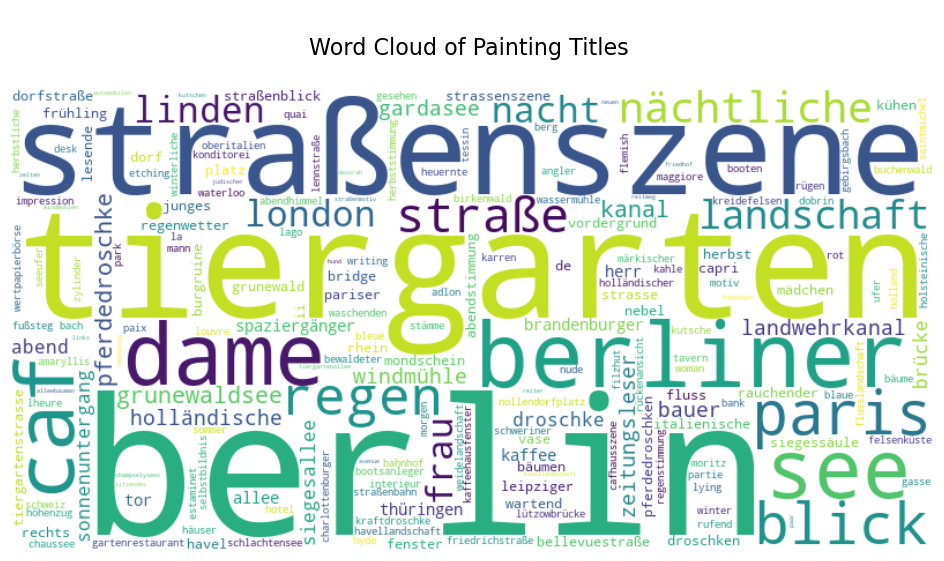

In [537]:
# get the token
tokens = " ".join(titles['clean_title'].tolist()).split()  
tokens_filtered = [word for word in tokens if word.lower() not in german_stopwords]


# WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white', collocations=False).generate(' '.join(tokens_filtered))

# make the words cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('\nWord Cloud of Painting Titles \n', fontsize=16)
plt.show();

## Progres Update

Great, by examining the titles we discovered - on average, a title contains 4-5 words, though some stretch up to 12. As expected, shorter words tend to appear more frequently - a general linguistic pattern where compact words are reused in familiar contexts.

It also became clear that title length varies by genre. *Landscape* paintings tend to have longer, more descriptive titles. *Cityscapes*, by contrast, often rely on recognition of well-known places: a phrase like *“Unter den Linden”* or *“Im Tiergarten”* is already enough to set the scene.

The frequency analysis reinforces this urban focus. City-related terms dominate the top of the list — *Berlin, Tiergarten, Straßenszene, Unter den Linden, Caf Bauer, Landwehrkanal, Grunewaldsee*. Certain bigrams and trigrams repeat frequently as well: *Im Regen, Bei Nacht, Am Grunewaldsee*. These patterns suggest a strong geographic consistency, especially centered around Berlin.

However, the genre distribution tells a more balanced story: there are actually slightly more landscape works (59) than cityscapes (57). The real difference lies in how the titles are composed. Landscapes tend to feature more unique words and rare combinations — likely reflecting a wider variety of locations and scenes. Cityscapes, in contrast, return to a limited set of motifs and places, which explains the higher word repetition.

The analysis of similar titles supports this idea. Dozens of artworks differ only by time of day, weather, or small scene variations. These are not mere repetitions, but studies — a way for Ury to observe his city from different angles, capturing its atmosphere in flux.

Among the recurring locations, we can identify some of Ury’s favorites: **Tiergarten, Unter den Linden, Landwehrkanal, Grunewaldsee, Caf Bauer**, and **Siegesallee**. These names appear again and again, anchoring his artistic world in specific, cherished corners of Berlin.

# Color Palette

Finally, we’ve reached the artist’s palette.\
In this section, I want to explore how the color palette changed depending on the genre of the artwork and the period of the artist’s career. Naturally, only paintings are included in the analysis — graphic works are excluded.

The process of creating a painting, and how color appears on the canvas through the mixing of paints, is complex. A single color, like “beige,” can include a wide range of shades. Therefore, just as I did when analyzing canvas sizes, I will apply rounding: to simplify the analysis, colors will be grouped by their nearest RGB values.

Let’s begin by loading the images.

In [538]:
# obtain the colors data 
palette = df[['id', 'url_imagine']].copy()
palette.sample(5)

,id,url_imagine
38,40,https://d7hftxdivxxvm.cloudfront.net/?height=4...
161,163,https://d7hftxdivxxvm.cloudfront.net/?height=4...
73,75,https://d7hftxdivxxvm.cloudfront.net/?height=4...
92,94,https://d7hftxdivxxvm.cloudfront.net/?height=4...
132,134,https://d7hftxdivxxvm.cloudfront.net/?height=4...


In [539]:
# # make the function for download images
# def download_images(file_path, save_folder):
#     """
#     Downloads images from links in a file and saves them with the name ID.
    
#     :param file_path: Path to the CSV file with columns id, title, url_imagine.
#     :param save_folder: Folder for saving images..
#     """
#     # create a folder if it doesn't exist
#     os.makedirs(save_folder, exist_ok=True)

    
#     for _, row in data.iterrows():
#         image_id = row['id']
#         image_url = row['url_imagine']
        
#         # file name
#         file_name = f"{image_id}.jpg"  
#         file_path = os.path.join(save_folder, file_name)
        
#         try:
#             # download image
#             response = requests.get(image_url, stream=True)
#             response.raise_for_status()  # checking if there's a mistake
            
#             # save image
#             with open(file_path, 'wb') as f:
#                 for chunk in response.iter_content(1024):
#                     f.write(chunk)
            
#             print(f"Image {file_name} saved successfully.")
#         except requests.RequestException as e:
#             print(f"Error while downloading {image_url}: {e}")

# # let's download images
# image_folder = "/Users/victorakulinin/Projects/lesser-ury-art-analysis/lesser_ury_image"  # folder for saved images
# download_images(palette, image_folder)


In [540]:
# # duplicate the value of the path to the image folder, as previous cell was commented out
image_folder = '/Users/victorakulinin/Projects/lesser-ury-art-analysis/lesser_ury_images/' 

In [541]:
# enrich the data with genre and period values
palette = (
    palette
    .merge(year[['id', 'period']], on='id', how='left')
    .merge(df[['id', 'genre']], on='id', how='left')
)

# create a mask for painting works
painting_ids = technics.query("tech_group == 'painting'")['id']

# excluded the graphic works
painting_palette = palette[palette['id'].isin(painting_ids)]

painting_palette.sample(3)

,id,url_imagine,period,genre
11,12,https://uploads6.wikiart.org/images/lesser-ury...,Berlin period,figure painting
171,173,https://d7hftxdivxxvm.cloudfront.net/?height=4...,Paris and Munich period,biblical scene
25,26,https://www.ludorff.com/assets/images/_large96...,Late period,cityscape


Great, we’ve downloaded the images — now let’s extract the dominant colors.

In [542]:

# make the fucntion for extracting dominant colors
def get_dominant_colors(image_path, k=5):
    """
    Extracts k dominant colors from an image using the K-Means clustering algorithm.

    :param image_path: Path to the image file.
    :param k: The number of dominant colors to extract. Defaults to 5.
    :return: A list of tuples, where each tuple (R, G, B) represents a dominant color.
    R, G, B values are integers.
    
    """
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image.reshape(-1, 3)
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(image)
    return [tuple(map(int, center)) for center in kmeans.cluster_centers_]

# add colors to the dataset
dominant_colors = []

for _, row in painting_palette.iterrows():
    img_id = row['id']
    img_path = os.path.join(image_folder, f"{img_id}.jpg")
    if os.path.exists(img_path):
        colors = get_dominant_colors(img_path)
        dominant_colors.append({'id': img_id, 'palette': colors})
    else:
        print(f"Image not found: {img_path}")

color_df = pd.DataFrame(dominant_colors)
painting_palette = painting_palette.merge(color_df, on='id')

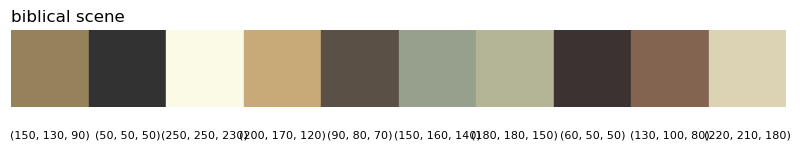

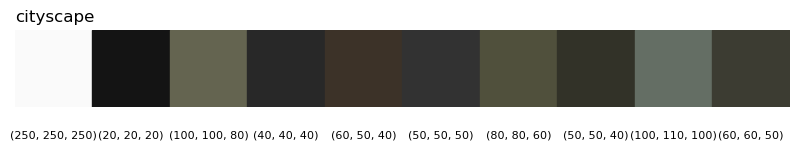

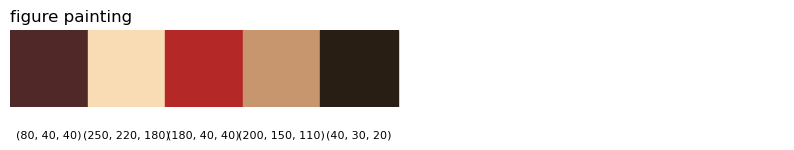

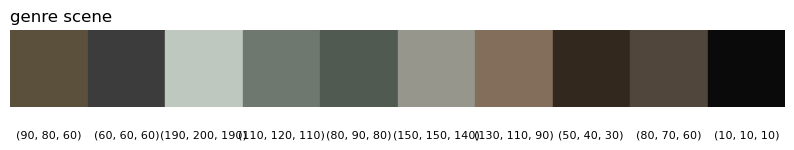

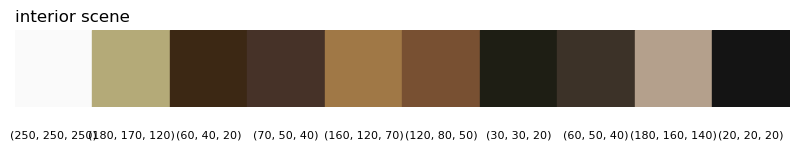

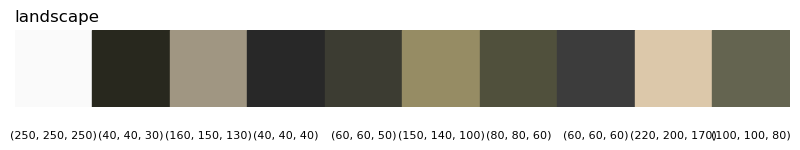

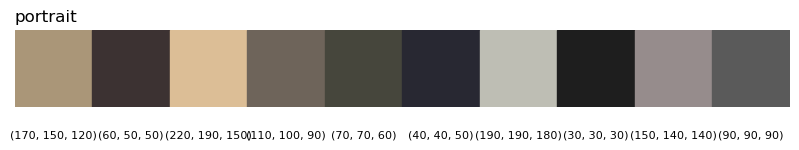

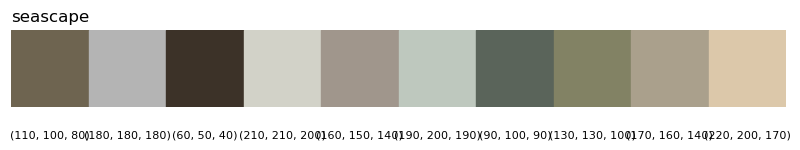

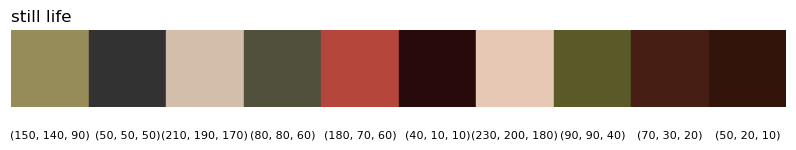

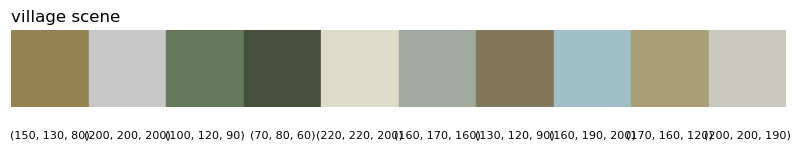

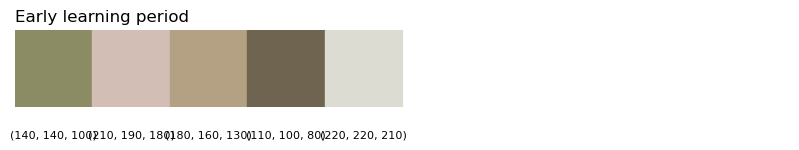

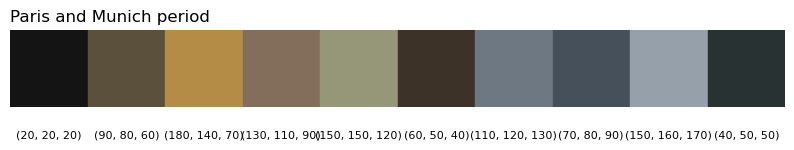

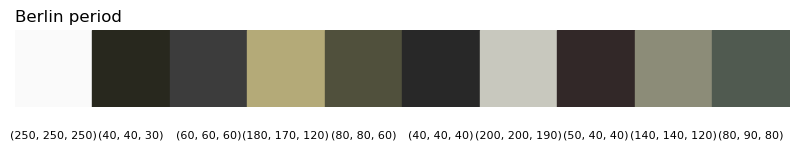

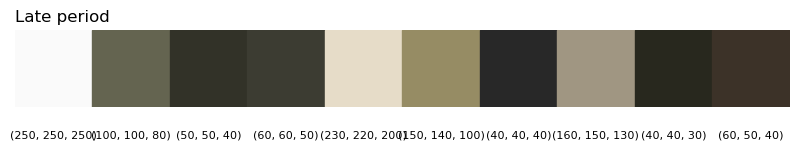

In [543]:

# a function for rounding color values
def round_color(rgb, base=10):
    """A function for rounding a color (R, G, B) to the nearest base."""
    return tuple(int(round(c / base) * base) for c in rgb)

# Custom order for periods
ordered_periods = [
    'Early learning period',
    'Paris and Munich period',
    'Berlin period',
    'Late period'
]

def plot_palette_by_group(data, group_col, title_prefix, ordered_groups=None):
    """
    Plots the top 10 most common rounded colors for each group with an overall heading.
    Groups will be sorted alphabetically by default, or use `ordered_groups` if provided.

    :param data: DataFrame with a 'palette' column and grouping column.
    :param group_col: Column to group by.
    :param title_prefix: Used as a section heading.
    :param ordered_groups: Optional custom order for group display.
    """
    from IPython.display import display, HTML

    display(HTML(f"<h2>{title_prefix}</h2>"))  # Section header
    
    groups = data[group_col].dropna().unique()
    if ordered_groups:
        groups = [g for g in ordered_groups if g in groups]
    else:
        groups = sorted(groups)

    for group in groups:
        group_df = data[data[group_col] == group]
        all_colors = []

        for palette in group_df['palette']:
            all_colors.extend([round_color(color) for color in palette])

        most_common = Counter(all_colors).most_common(10)
        colors = [color for color, _ in most_common]

        # Visualization
        fig, ax = plt.subplots(figsize=(10, 1))
        for i, color in enumerate(colors):
            ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=[c / 255 for c in color]))
            ax.text(i + 0.5, -0.3, str(color), ha='center', va='top', fontsize=8)


        ax.set_xlim(0, 10)
        ax.set_ylim(0, 1)
        ax.axis('off')
        plt.title(f"{group}", loc='left', fontsize=12)
        plt.show();

plot_palette_by_group(painting_palette, group_col='genre', title_prefix='Palettes by genre')
plot_palette_by_group(painting_palette, group_col='period', title_prefix='Palette by periods', ordered_groups=ordered_periods)

In [544]:
painting_palette.columns

Index(['id', 'url_imagine', 'period', 'genre', 'palette'], dtype='object')

We now have the following:

- *Cityscape*: A muted, subdued palette with dark blue, grey, and olive tones. It gives a gloomy, urban-industrial atmosphere.
- *Landscape*: A lighter palette with cream, grey-blue, and olive shades. It feels more open and airy.
- *Genre scene and Interior scene*: Rich, warm browns dominate. These are the colors of interiors, shadows, and night scenes. Black and dark red are especially noticeable.
- *Figure painting*: Strong contrast. Against almost black backgrounds, we see deep red and scarlet - possibly highlighting emotion and drama.
- *Still life*: A diverse and colorful palette, with red, olive, and golden tones. The colors feel rich and focused on objects.
- *Village scene*: Mainly green and blue tones - suggesting nature and calm.
- *Seascape*: Light, neutral colors with lots of sandy and grey tones - reflecting water and a peaceful atmosphere.
- *Portrait*: Balanced and cool-toned palette, with grey, bluish-purple, and skin-like shades. It feels calm and focused.
- *Biblical scene*: Neutral and light, with beige and green tones. Possibly used to convey symbolism and restraint.

So, regarding the palette's evolution across different periods:

In the *early learning period*, Ury’s palette is soft and warm. We see beige, brown, and light gray tones. There are no deep contrasts or strong blacks - the colors feel gentle and academic, reflecting a more classical approach. This is the lightest palette overall.

During the *Paris and Munich period*, the palette becomes much richer and more varied. Deep dark tones appear, along with warm browns and greens. There are also some cool grays and blues. The contrast is stronger, possibly influenced by French painting styles of the time.

In the *Berlin period*, the colors get darker and more urban. We see strong contrasts between light beige and deep black, gray, and brown. The palette feels denser and more serious - matching Ury’s focus on city life, especially Berlin at night.

In the *late period*, the tones stay mostly dark but become slightly warmer. Soft beige, olive, and muted browns appear more often. The contrasts are not as sharp as before - the palette feels calmer and more introspective.

## Progres update

Before summarizing the results, it’s worth pointing out two limitations that may affect the overall conclusions.
First, the dataset is relatively small and unevenly distributed across genres and periods.
Second, all images were sourced from open online platforms, and I have no information about whether they were modified - through filters, color correction, or compression.
That said, this is not an academic study. We're analyzing simplified, rounded RGB values, so I treat the results as useful approximations rather than precise measurements.

Now to the observations:

Warm, earthy tones - browns, ochres, muted greens and grays - dominate almost every genre. This matches Ury’s realistic style and his attachment to both urban and natural environments.

Deep dark shades - black, dark brown, charcoal - are especially common in genres where atmosphere plays a central role: genre scenes, cityscapes, and interiors. These tones support the mood of night, rain, or enclosed space.

In general, landscape-related genres show greater color diversity. Urban scenes, by contrast, use a more limited palette - but this limitation works in favor of expressive atmosphere and visual cohesion.

When looking across periods, we see a clear shift.
The early period is marked by soft, warm tones - intimate and calm.
In the Berlin period, the palette becomes darker and more intense - reflecting urban night scenes and emotional depth.
In the late period, Ury moves toward slightly lighter, more stable colors, perhaps signaling a more reflective or settled phase of life.

In [545]:
stop


NameError: name 'stop' is not defined

In [551]:
profile = df[['id']].copy()

profile = (
    profile
    .merge(year[['id', 'period']], on='id', how='left')
    .merge(titles[['id', 'super_genre']], on='id', how='left')
    .merge(support[['id', 'support_corect']], on='id', how='left')
    .merge(technics[['id', 'tech_group']], on='id', how='left')
    .merge(dimension[['id', 'size_category']], on='id', how='left')    
)

profile.describe(include = 'all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,181.0,NaN,NaN,NaN,91.81768,52.654059,1.0,47.0,92.0,137.0,182.0
period,181,4,Berlin period,119,NaN,NaN,NaN,NaN,NaN,NaN,NaN
super_genre,181,3,landscapes,129,NaN,NaN,NaN,NaN,NaN,NaN,NaN
support_corect,181,5,canvas,66,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tech_group,181,2,painting,137,NaN,NaN,NaN,NaN,NaN,NaN,NaN
size_category,181,4,medium,97,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [552]:
# Закодируем категориальные переменные
encoded = pd.get_dummies(profile[['period', 'super_genre', 'support_corect', 'tech_group', 'size_category']], 
                         drop_first=False)

# Объединяем с id
df_encoded = pd.concat([profile[['id', 'period']], encoded.drop(columns=['period_Berlin period', 'period_Early learning period',
                                                                     'period_Late period', 'period_Paris and Munich period'])], axis=1)

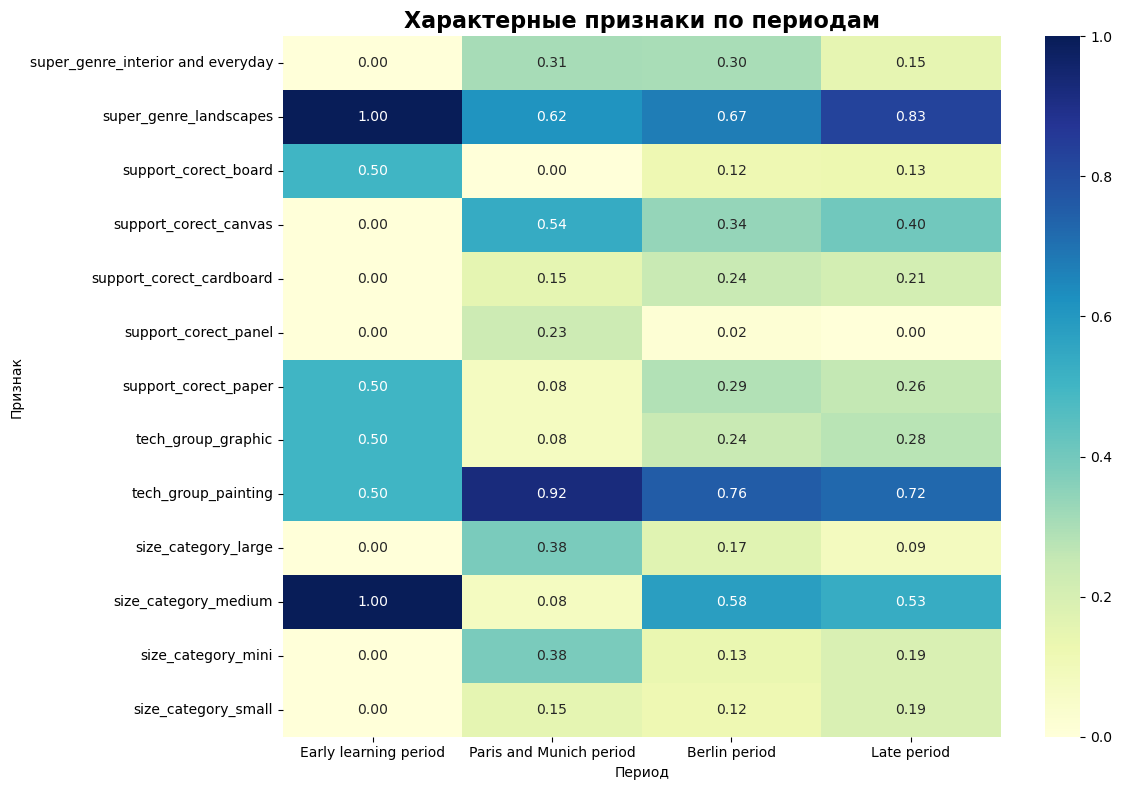

In [568]:
#import pandas as pd
import seaborn as sns
#import matplotlib.pyplot as plt

# Группировка: среднее значение по признакам для каждого периода
period_profile = (
    df_encoded.drop(columns=['id'])
    .groupby('period', observed=False)
    .mean()
    .T  # транспонируем для удобства
)

# Фильтруем признаки, где хотя бы в одном периоде значение > 0.15
selected_features = period_profile[period_profile.max(axis=1) > 0.15]

# Визуализация
plt.figure(figsize=(12, 8))
sns.heatmap(selected_features, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Характерные признаки по периодам", fontsize=16, weight='bold')
plt.xlabel("Период")
plt.ylabel("Признак")
plt.tight_layout()
plt.show();
